In [214]:
#load in packages and initial config
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from sklearn import linear_model
import seaborn as sns
import tkinter as tk 
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from numpy import *
from scipy.interpolate import *
pd.set_option("display.max_columns", 100,"display.max_rows",80)
# from scipy.interpolate import *

In [99]:
dpdcalls = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/dpdshapefilelatlong/dpdshapefilelatlong.shp')
dpdcalls = dpdcalls.loc[~(dpdcalls["X"] == 0) & ~(dpdcalls["Y"] == 0)].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
twotosix = ['2', '3', '4', '5', '6']
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(twotosix)].copy()
dpdcalls

Event Numb Case Numbe   Call Date   Call Time             Source  \
0         21000002       None    1/1/2021  12:00:28AM  Wireless 911 Call   
1         21000006       None    1/1/2021  12:01:41AM  Wireless 911 Call   
2         21000007       None    1/1/2021  12:01:45AM  Wireless 911 Call   
3         21000008       None    1/1/2021  12:02:10AM  Wireless 911 Call   
4         21000010       None    1/1/2021  12:02:39AM  Wireless 911 Call   
...            ...        ...         ...         ...                ...   
278265    21478310       None  12/31/2021  11:40:03PM              E-911   
278266    21478311       None  12/31/2021  11:40:26PM  Wireless 911 Call   
278267    21478321       None  12/31/2021  11:45:14PM  Wireless 911 Call   
278271    21478336       None  12/31/2021  11:51:01PM  Wireless 911 Call   
278272    21478338       None  12/31/2021  11:51:22PM  Wireless 911 Call   

       Priority                  Nature                       Address  \
0             3          SOUND OF SHOTS            100 PEBBLESTONE DR   
1             3          SOUND OF SHOTS       CARROLL ST/MOREHEAD AVE   
2             3          SOUND OF SHOTS                1300 SHILEY DR   
3             3          SOUND OF SHOTS               0 EDGEBROOK CIR   
4             3          SOUND OF SHOTS                  1200 ALMA ST   
...         ...                     ...                           ...   
278265        4         NOISE COMPLAINT           300 CHERRY GROVE ST   
278266        3          SOUND OF SHOTS  E CORNWALLIS RD/S ROXBORO ST   
278267        3    SUSPICIOUS  ACTIVITY             2400 GLENBROOK DR   
278271        3    TRESPASS OR UNWANTED         1600 T W ALEXANDER DR   
278272        2  UNKNOWN PROBLEM POLICE            3700 MERIWETHER DR   

              X       Y District Beat               Dispositio  Cancelled  \
0       2055372  818537       D1  121  Resolved Without Report          0   
1       2024961  815902       D3  312  Resolved Without Report          0   
2       2038061  841530       D2  223  Resolved Without Report          0   
3       2045947  796806       D4  414  Resolved Without Report          0   
4       2037016  818259       D1  112  Resolved Without Report          0   
...         ...     ...      ...  ...                      ...        ...   
278265  2035589  814710       D1  113  Resolved Without Report          0   
278266  2023820  806257       D4  412  Resolved Without Report          0   
278267  2036593  828406       D2  214  Resolved Without Report          0   
278271  2045831  791379       D4  423                Unfounded          0   
278272  2032628  832985       D2  223  Resolved Without Report          0   

                          geometry  
0       POINT (-78.81280 35.99886)  
1       POINT (-78.91562 35.99174)  
2       POINT (-78.87123 36.06210)  
3       POINT (-78.84478 35.93921)  
4       POINT (-78.87486 35.99818)  
...                            ...  
278265  POINT (-78.87970 35.98843)  
278266  POINT (-78.91950 35.96525)  
278267  POINT (-78.87625 36.02605)  
278271  POINT (-78.84520 35.92430)  
278272  POINT (-78.88964 36.03865)  

[109278 rows x 15 columns]

In [100]:
callsperaddress = dpdcalls.groupby( ["Address"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callsperaddress.sort_values(by='dpdcalls_count', inplace=True, ascending=False)
callsperaddress

Address  dpdcalls_count
3679            200 S MANGUM ST             892
5779       3400 HILLSBOROUGH RD             826
5967          3600 N ROXBORO ST             808
7619   5400 NEW HOPE COMMONS DR             608
8173       6900 FAYETTEVILLE RD             585
...                         ...             ...
6921           4700 DENFIELD ST               1
6920             4700 DANUBE LN               1
6917              4700 CORAL DR               1
6916          4700 CHICOPEE TRL               1
12724      YOUNG AVE/ANGIER AVE               1

[12725 rows x 2 columns]

In [101]:
policebeats = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/Police_Beats/Police_Beats.shp')
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["Beat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

LAWBEAT                                           geometry  OBJECTID  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2      113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3      114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4      121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

      PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  26265.849609      I        yes      D1  112       None  2.079934e+07   
2  20667.539062      I        yes      D1  113       None  2.159195e+07   
3  53321.980469      I        yes      D1  114       None  6.103382e+07   
4  14495.120117      I         no      D1  121       None  7.008533e+06   

     ShapeSTLen  Beat  id  
0  28608.799743   111   0  
1  26265.852604   112   1  
2  20667.538873   113   2  
3  53321.974873   114   3  
4  14495.120026   121   4

In [102]:
hispanicdata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanic data/hispanicdata.csv', skiprows =1)
hispanicdata['GEOID20'] = hispanicdata['id'].str[-15:]
hispanicdata.drop('id', axis=1, inplace=True)
hispanicdata.drop(hispanicdata.iloc[:, 4:74], inplace = True, axis = 1)
hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[#,@,&,!]', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[:]', '_')
hispanicdata.rename(columns = {'total_':'total', 'total_not_hispanic_or_latino_':'total_not_hispanic_or_latino'}, inplace = True)
hispanicdata

geographic_area_name  total  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...    108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...     35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...     38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...     43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...     31   
...                                                 ...    ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...      0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...      0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...      0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...      0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...      0   

      total_hispanic_or_latino  total_not_hispanic_or_latino          geoid20  
0                           25                            83  370630001011000  
1                           12                            23  370630001011001  
2                            8                            30  370630001011002  
3                            0                            43  370630001011003  
4                            7                            24  370630001011004  
...                        ...                           ...              ...  
4396                         0                             0  370639801001068  
4397                         0                             0  370639801001069  
4398                         0                             0  370639801001070  
4399                         0                             0  370639801001071  
4400                         0                             0  370639801001072  

[4401 rows x 5 columns]

In [103]:
ncblockmap = gpd.read_file('/Users/erikrobertsson/Downloads/Northcarolinablocksshapefiles/tl_2021_37_tabblock20.shp')
ncblockmap = ncblockmap.to_crs("EPSG:4326")
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [104]:
durhamhispanicmap = pd.merge(hispanicdata, durhamblockmap, left_on ='geoid20', right_on='GEOID20')
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'geoid20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap

geographic_area_name  total  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...    108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...     35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...     38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...     43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...     31   
...                                                 ...    ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...      0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...      0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...      0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...      0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...      0   

      total_hispanic_or_latino  total_not_hispanic_or_latino COUNTYFP20  \
0                           25                            83        063   
1                           12                            23        063   
2                            8                            30        063   
3                            0                            43        063   
4                            7                            24        063   
...                        ...                           ...        ...   
4396                         0                             0        063   
4397                         0                             0        063   
4398                         0                             0        063   
4399                         0                             0        063   
4400                         0                             0        063   

              GEOID20   INTPTLAT20    INTPTLON20  \
0     370630001011000  +36.0194814  -078.8821382   
1     370630001011001  +36.0205516  -078.8893121   
2     370630001011002  +36.0205916  -078.8869754   
3     370630001011003  +36.0205318  -078.8880959   
4     370630001011004  +36.0221289  -078.8796703   
...               ...          ...           ...   
4396  370639801001068  +35.8697575  -078.8648679   
4397  370639801001069  +35.8691012  -078.8652956   
4398  370639801001070  +35.8687255  -078.8673419   
4399  370639801001071  +35.8957583  -078.8703320   
4400  370639801001072  +35.9385678  -078.8788750   

                                               geometry  
0     POLYGON ((-78.88999 36.01852, -78.88995 36.019...  
1     POLYGON ((-78.88993 36.02006, -78.88990 36.021...  
2     POLYGON ((-78.88749 36.02015, -78.88746 36.021...  
3     POLYGON ((-78.88872 36.01988, -78.88867 36.021...  
4     POLYGON ((-78.88098 36.02211, -78.87993 36.022...  
...                                                 ...  
4396  POLYGON ((-78.86527 35.87076, -78.86499 35.870...  
4397  POLYGON ((-78.86569 35.87062, -78.86540 35.870...  
4398  POLYGON ((-78.87004 35.86799, -78.86978 35.868...  
4399  POLYGON ((-78.87243 35.89600, -78.87216 35.896...  
4400  POLYGON ((-78.87930 35.93618, -78.87928 35.937...  

[4401 rows x 9 columns]

In [105]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

In [106]:
cblockcommsafebeats = cblockDurhamBeats.copy()
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
cblockcommsafebeats = cblockDurhamBeats.loc[cblockDurhamBeats['Beat'].isin(commsafe_list)].copy()
cblockcommsafebeats

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
874           37        063    001709      3001  370630017093001  Block 3001   
3649          37        063    001801      6041  370630018016041  Block 6041   
10944         37        063    000101      1028  370630001011028  Block 1028   
11876         37        063    001801      6033  370630018016033  Block 6033   
12204         37        063    001801      7005  370630018017005  Block 7005   
...          ...        ...       ...       ...              ...         ...   
235109        37        063    002200      2031  370630022002031  Block 2031   
235830        37        063    002300      1027  370630023001027  Block 1027   
236139        37        063    002200      2048  370630022002048  Block 2048   
236183        37        063    002200      1012  370630022001012  Block 1012   
236438        37        063    001301      1001  370630013011001  Block 1001   

       MTFCC20 UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20  \
874      G5040    R   None     None          S   918860      1497   
3649     G5040    R   None     None          S   212123      9487   
10944    G5040    R   None     None          S   435000      2847   
11876    G5040    R   None     None          S   131608      6435   
12204    G5040    R   None     None          S    11498      1223   
...        ...  ...    ...      ...        ...      ...       ...   
235109   G5040    R   None     None          S    14546         0   
235830   G5040    R   None     None          S    57219         0   
236139   G5040    R   None     None          S    10849         0   
236183   G5040    R   None     None          S    11653         0   
236438   G5040    R   None     None          S    40022         0   

         INTPTLAT20    INTPTLON20  \
874     +36.0511955  -078.8989718   
3649    +36.0155379  -078.8706505   
10944   +36.0161756  -078.8795383   
11876   +36.0263370  -078.8611270   
12204   +36.0602307  -078.8586903   
...             ...           ...   
235109  +35.9983414  -078.8990835   
235830  +35.9854948  -078.9077482   
236139  +35.9949422  -078.8981501   
236183  +36.0007075  -078.9093748   
236438  +35.9810471  -078.8944621   

                                                 geometry  Beat  
874     POLYGON ((-78.90312 36.05133, -78.90294 36.051...   223  
3649    POLYGON ((-78.87550 36.01421, -78.87371 36.014...   214  
10944   POLYGON ((-78.88806 36.01514, -78.88790 36.015...   214  
11876   POLYGON ((-78.86503 36.02665, -78.86499 36.026...   214  
12204   POLYGON ((-78.85984 36.06053, -78.85929 36.060...   214  
...                                                   ...   ...  
235109  POLYGON ((-78.89994 35.99915, -78.89961 35.998...   512  
235830  POLYGON ((-78.90906 35.98449, -78.90900 35.984...   411  
236139  POLYGON ((-78.89883 35.99520, -78.89876 35.995...   512  
236183  POLYGON ((-78.90950 36.00138, -78.90934 36.001...   511  
236438  POLYGON ((-78.89541 35.98186, -78.89539 35.981...   411  

[533 rows x 17 columns]

In [107]:
durhamhispanicmap = durhamblockmap.set_index('GEOID20').join(hispanicdata.set_index('geoid20'))
durhamhispanicmap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamhispanicmap.head(3)

COUNTYFP20   INTPTLAT20    INTPTLON20  \
GEOID20                                                 
370630018064007        063  +36.0127651  -078.8227713   
370630018017028        063  +36.0696478  -078.7923950   
370630021004022        063  +36.1529771  -078.8218382   

                                                          geometry  \
GEOID20                                                              
370630018064007  POLYGON ((-78.82464 36.01317, -78.82456 36.013...   
370630018017028  POLYGON ((-78.80507 36.06321, -78.80468 36.063...   
370630021004022  POLYGON ((-78.83005 36.15073, -78.83001 36.150...   

                                              geographic_area_name  total  \
GEOID20                                                                     
370630018064007  Block 4007, Block Group 4, Census Tract 18.06,...     80   
370630018017028  Block 7028, Block Group 7, Census Tract 18.01,...      0   
370630021004022  Block 4022, Block Group 4, Census Tract 21, Du...     88   

                 total_hispanic_or_latino  total_not_hispanic_or_latino  
GEOID20                                                                  
370630018064007                        33                            47  
370630018017028                         0                             0  
370630021004022                         0                            88

In [108]:
blockswithhispanics = gpd.sjoin(durhamhispanicmap, cblockcommsafebeats)
blockswithhispanics['prophispanic']= blockswithhispanics['total_hispanic_or_latino'] / blockswithhispanics['total']
blockswithhispanics.head(3)

COUNTYFP20_left INTPTLAT20_left INTPTLON20_left  \
GEOID20                                                           
370630018017041             063     +36.0558254    -078.8296616   
370630018016014             063     +36.0496473    -078.8467110   
370630018016009             063     +36.0426464    -078.8352676   

                                                          geometry  \
GEOID20                                                              
370630018017041  POLYGON ((-78.83393 36.05431, -78.83344 36.055...   
370630018016014  POLYGON ((-78.85572 36.04408, -78.85557 36.044...   
370630018016009  POLYGON ((-78.84667 36.03546, -78.84547 36.037...   

                                              geographic_area_name  total  \
GEOID20                                                                     
370630018017041  Block 7041, Block Group 7, Census Tract 18.01,...      9   
370630018016014  Block 6014, Block Group 6, Census Tract 18.01,...    195   
370630018016009  Block 6009, Block Group 6, Census Tract 18.01,...     97   

                 total_hispanic_or_latino  total_not_hispanic_or_latino  \
GEOID20                                                                   
370630018017041                         3                             6   
370630018016014                        79                           116   
370630018016009                        27                            70   

                 index_right STATEFP20 COUNTYFP20_right TRACTCE20 BLOCKCE20  \
GEOID20                                                                       
370630018017041       225453        37              063    001801      6008   
370630018016014       225453        37              063    001801      6008   
370630018016009       225453        37              063    001801      6008   

                         GEOID20      NAME20 MTFCC20 UR20 UACE20 UATYPE20  \
GEOID20                                                                     
370630018017041  370630018016008  Block 6008   G5040    R   None     None   
370630018016014  370630018016008  Block 6008   G5040    R   None     None   
370630018016009  370630018016008  Block 6008   G5040    R   None     None   

                FUNCSTAT20  ALAND20  AWATER20 INTPTLAT20_right  \
GEOID20                                                          
370630018017041          S   100889         0      +36.0519717   
370630018016014          S   100889         0      +36.0519717   
370630018016009          S   100889         0      +36.0519717   

                INTPTLON20_right  Beat  prophispanic  
GEOID20                                               
370630018017041     -078.8336224   214      0.333333  
370630018016014     -078.8336224   214      0.405128  
370630018016009     -078.8336224   214      0.278351

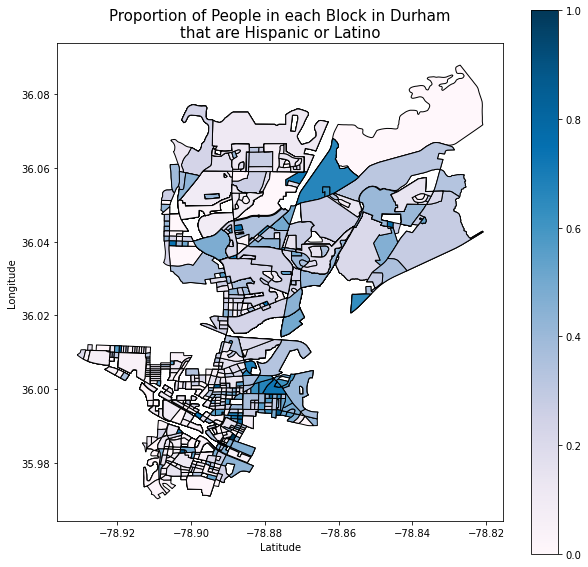

In [109]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
blockswithhispanics.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Block in Durham\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

start of checking how callcountperperson correlates with a beats popdensity

In [110]:
beatswithhispanics = pd.merge(cblockDurhamBeats, hispanicdata, left_on ='GEOID20', right_on='geoid20')
#beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
popsumbybeat

Beat   ALAND20  AWATER20  total  total_hispanic_or_latino  \
0    111   1885019         0   3949                      1130   
1    112   1863048         0   3083                      1366   
2    113   2056983      1025   4094                      1038   
3    114   5975063     40919   5631                      1756   
4    121  12440369    123268   8025                      1803   
5    122   3167854      1644   3209                      1478   
6    123   7274612     85253   9036                      2629   
7    124  32035320    303409  14913                      1106   
8    211   5952891         0   6544                       965   
9    212   4111458         0   7901                      1256   
10   213   4283757       726   4962                      1528   
11   214  10682867     67825   6628                      1599   
12   221  18543956    286750  10284                       894   
13   222  10207102    104412  10888                      2800   
14   223   7320693     10035   8338                      1424   
15   224  20690360    239137  11682                      1335   
16   299  20342184   2127232    540                        11   
17   311   5501014         0   6954                      1014   
18   312   6289989      1510   7865                      1087   
19   313   6394389     17244  12372                      1713   
20   314   4896804      4206   6616                      1682   
21   321  15209054     79582   9605                      1377   
22   322  15676836     26434  15927                      1064   
23   323  10465852     66717   9264                       874   
24   324  15404774    104090  10982                       658   
25   411   2012555       757   3261                       446   
26   412   5331786      8163   7737                       885   
27   413   5690030      7478   4808                      1221   
28   414  13256904     57600  10761                      1486   
29   415   8174160    106957   9436                      1535   
30   421  10243290    118655  13874                      1503   
31   422  14355083    235549  11497                      1068   
32   423  25160283    240192  15092                      1231   
33   511   2044774         0   5505                       385   
34   512    882799         0   1646                       119   
35   513    797193         0   1677                       180   
36   999   2187405     14257    194                        43   

    total_not_hispanic_or_latino  
0                           2819  
1                           1717  
2                           3056  
3                           3875  
4                           6222  
5                           1731  
6                           6407  
7                          13807  
8                           5579  
9                           6645  
10                          3434  
11                          5029  
12                          9390  
13                          8088  
14                          6914  
15                         10347  
16                           529  
17                          5940  
18                          6778  
19                         10659  
20                          4934  
21                          8228  
22                         14863  
23                          8390  
24                         10324  
25                          2815  
26                          6852  
27                          3587  
28                          9275  
29                          7901  
30                         12371  
31                         10429  
32                         13861  
33                          5120  
34                          1527  
35                          1497  
36                           151

In [111]:
popsumbybeat['total'].sum()


284780

In [112]:
blocks_w_dpd = gpd.sjoin(cblockcommsafebeats, dpdcalls)
callssummedinblocks = blocks_w_dpd.groupby(['NAME20']).size().to_frame(name = 'calls_count').reset_index()
callssummedinblocks

NAME20  calls_count
0    Block 1000         1017
1    Block 1001          333
2    Block 1002         1210
3    Block 1003          288
4    Block 1004          382
..          ...          ...
204  Block 7035           36
205  Block 7036           45
206  Block 7042            8
207  Block 7043           38
208  Block 7044            6

[209 rows x 2 columns]

In [113]:
blocks_calls_w_callcount = pd.merge(blocks_w_dpd, callssummedinblocks, left_on ='NAME20', right_on='NAME20')
blocks_calls_w_callcount = blocks_calls_w_callcount.groupby('NAME20', as_index=False).mean()
blocks_calls_w_callcount.sort_values(by='calls_count', inplace=True, ascending=False)
blocks_calls_w_callcount

NAME20        ALAND20    AWATER20   Beat_left    index_right  \
2    Block 1002   53516.946281  242.695041  456.133058  148159.120661   
50   Block 2000  607699.781485    0.000000  206.002502  144707.322769   
0    Block 1000  506083.700098    0.000000  236.846608  144648.589971   
6    Block 1006  124547.767160    0.000000  214.670256  146645.969044   
195  Block 7000  479174.000000    0.000000  223.000000  147654.715517   
..          ...            ...         ...         ...            ...   
175  Block 6014   13169.000000    0.000000  223.000000   88329.500000   
191  Block 6038   16599.000000    0.000000  214.000000   71771.500000   
198  Block 7013   21593.000000    0.000000  214.000000  107172.000000   
106  Block 2056    3244.000000    0.000000  512.000000  116996.000000   
111  Block 2061    7542.000000    0.000000  513.000000  265686.000000   

       Event Numb             X              Y  Cancelled  calls_count  
2    2.124701e+07  2.030198e+06  817123.894215        0.0       1210.0  
50   2.124094e+07  2.034296e+06  827418.895746        0.0       1199.0  
0    2.124101e+07  2.032666e+06  823523.182891        0.0       1017.0  
6    2.124463e+07  2.033717e+06  820417.946164        0.0        743.0  
195  2.124649e+07  2.031695e+06  833113.176724        0.0        696.0  
..            ...           ...            ...        ...          ...  
175  2.114515e+07  2.033480e+06  834297.500000        0.0          2.0  
191  2.111482e+07  2.038558e+06  825727.500000        0.0          2.0  
198  2.117259e+07  2.040704e+06  837944.000000        0.0          1.0  
106  2.118913e+07  2.029680e+06  816595.000000        0.0          1.0  
111  2.145575e+07  2.030260e+06  815975.000000        0.0          1.0  

[209 rows x 10 columns]

In [114]:
mappingdatasetforblocks_w_calls = pd.merge(cblockcommsafebeats, blocks_calls_w_callcount, on ='NAME20')
mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.to_crs("4326")
mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.dissolve(by="NAME20")
mappingdatasetforblocks_w_calls['area'] = mappingdatasetforblocks_w_calls.area
mappingdatasetforblocks_w_calls['callsperarea'] = mappingdatasetforblocks_w_calls['calls_count'] / mappingdatasetforblocks_w_calls['area']
mappingdatasetforblocks_w_calls.sort_values(by='calls_count', inplace=True, ascending=False)
#block_list = ['1002', '2000', '1000', '1006', '7000']
#mappingdatasetforblocks_w_calls = mappingdatasetforblocks_w_calls.loc[mappingdatasetforblocks_w_calls['BLOCKCE20'].isin(block_list)].copy()
#mappingdatasetforblocks_w_calls.to_file("/Users/erikrobertsson/Documents/dataplus/blockdataforcommsafebeats.shp")
mappingdatasetforblocks_w_calls

geometry STATEFP20  \
NAME20                                                                    
Block 1002  MULTIPOLYGON (((-78.90784 35.97892, -78.90778 ...        37   
Block 2000  MULTIPOLYGON (((-78.89454 35.97666, -78.89304 ...        37   
Block 1000  MULTIPOLYGON (((-78.90063 35.97796, -78.90043 ...        37   
Block 1006  MULTIPOLYGON (((-78.89588 35.98054, -78.89615 ...        37   
Block 7000  POLYGON ((-78.89929 36.04016, -78.89916 36.040...        37   
...                                                       ...       ...   
Block 6014  POLYGON ((-78.88816 36.04244, -78.88749 36.042...        37   
Block 6038  POLYGON ((-78.87068 36.01841, -78.86987 36.019...        37   
Block 7013  POLYGON ((-78.86311 36.05239, -78.86301 36.052...        37   
Block 2056  POLYGON ((-78.90046 35.99401, -78.90002 35.993...        37   
Block 2061  POLYGON ((-78.89903 35.99301, -78.89886 35.992...        37   

           COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20 MTFCC20 UR20  \
NAME20                                                                    
Block 1002        063    001709      1002  370630017091002   G5040    R   
Block 2000        063    002200      2000  370630022002000   G5040    R   
Block 1000        063    000101      1000  370630001011000   G5040    R   
Block 1006        063    001301      1006  370630013011006   G5040    R   
Block 7000        063    001709      7000  370630017097000   G5040    R   
...               ...       ...       ...              ...     ...  ...   
Block 6014        063    001709      6014  370630017096014   G5040    R   
Block 6038        063    001801      6038  370630018016038   G5040    R   
Block 7013        063    001801      7013  370630018017013   G5040    R   
Block 2056        063    002200      2056  370630022002056   G5040    R   
Block 2061        063    002200      2061  370630022002061   G5040    R   

           UACE20 UATYPE20 FUNCSTAT20  ALAND20_x  AWATER20_x   INTPTLAT20  \
NAME20                                                                      
Block 1002   None     None          S     158601        4383  +36.0421211   
Block 2000   None     None          S      40275           0  +36.0024055   
Block 1000   None     None          S     655575           0  +36.0194814   
Block 1006   None     None          S       9723           0  +35.9802719   
Block 7000   None     None          S     479174           0  +36.0390725   
...           ...      ...        ...        ...         ...          ...   
Block 6014   None     None          S      13169           0  +36.0423077   
Block 6038   None     None          S      16599           0  +36.0185436   
Block 7013   None     None          S      21593           0  +36.0512958   
Block 2056   None     None          S       3244           0  +35.9934559   
Block 2061   None     None          S       7542           0  +35.9914913   

              INTPTLON20  Beat      ALAND20_y  AWATER20_y   Beat_left  \
NAME20                                                                  
Block 1002  -078.8777243   214   53516.946281  242.695041  456.133058   
Block 2000  -078.8942098   111  607699.781485    0.000000  206.002502   
Block 1000  -078.8821382   214  506083.700098    0.000000  236.846608   
Block 1006  -078.8965798   411  124547.767160    0.000000  214.670256   
Block 7000  -078.8935405   223  479174.000000    0.000000  223.000000   
...                  ...   ...            ...         ...         ...   
Block 6014  -078.8869149   223   13169.000000    0.000000  223.000000   
Block 6038  -078.8696624   214   16599.000000    0.000000  214.000000   
Block 7013  -078.8610810   214   21593.000000    0.000000  214.000000   
Block 2056  -078.8994425   512    3244.000000    0.000000  512.000000   
Block 2061  -078.8974158   513    7542.000000    0.000000  513.000000   

              index_right    Event Numb             X              Y  \
NAME20                                                                 
Block

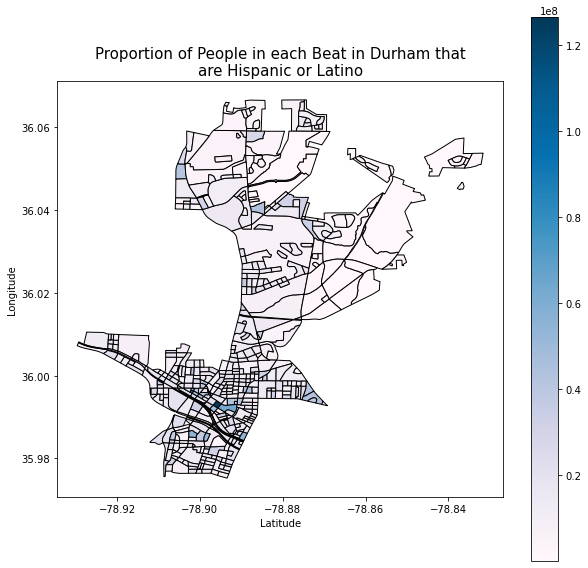

In [115]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforblocks_w_calls.plot(column='callsperarea',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [116]:
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
callssummedinbeats = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
callssummedinbeats

LAWBEAT  calls_count
0       111         2477
1       112         2334
2       113         2839
3       114         2805
4       121         2495
5       122         3070
6       123         2612
7       124         1827
8       211         3736
9       212         3167
10      213         3478
11      214         3511
12      221         3847
13      222         3021
14      223         4826
15      224         2462
16      299            2
17      311         2577
18      312         2628
19      313         3423
20      314         3049
21      321         3089
22      322         2388
23      323         2656
24      324         3439
25      411         3415
26      412         3149
27      413         3179
28      414         3268
29      415         2799
30      421         4181
31      422         4137
32      423         5289
33      511         2298
34      512         2685
35      513         2658
36      999           41

In [117]:
policebeats_calls_w_callcount = pd.merge(policebeats_w_dpd, callssummedinbeats, left_on ='LAWBEAT', right_on='LAWBEAT')
policebeats_calls_w_callcount['area'] = policebeats_calls_w_callcount.area
policebeats_calls_w_callcount = policebeats_calls_w_callcount.groupby('LAWBEAT', as_index=False).mean()
policebeats_calls_w_callcount

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
5       122      54.0   36686.679688  3.436298e+07   36686.681354      122.0   
6       123      55.0   74375.859375  7.495698e+07   74375.856455      123.0   
7       124      63.0   10708.070312  3.022588e+06   10708.070450      124.0   
8       211      36.0   36748.878906  6.487864e+07   36748.875052      211.0   
9       212      43.0   37127.789062  4.301152e+07   37127.786492      212.0   
10      213      37.0   28560.539062  4.691512e+07   28560.540431      213.0   
11      214      23.0    1715.291016  1.329736e+05    1715.290848      214.0   
12      221      17.0   87384.078125  2.027947e+08   87384.076005      221.0   
13      222      16.0   50498.308594  1.066247e+08   50498.309761      222.0   
14      223      21.0   16095.400391  6.891411e+06   16095.395041      223.0   
15      224      12.0   94210.453125  7.014559e+07   94210.453140      224.0   
16      299       1.0   29657.869141  2.075708e+07   29657.868615      299.0   
17      311      66.0   48409.859375  6.081916e+07   48409.861058      311.0   
18      312      52.0   42676.800781  6.884782e+07   42676.796572      312.0   
19      313      39.0   57403.839844  6.812116e+07   57403.841356      313.0   
20      314      78.0   38782.281250  5.416068e+07   38782.281943      314.0   
21      321      58.0  122575.601562  1.593645e+08  122575.571649      321.0   
22      322      87.0   60429.371094  1.639988e+08   60429.372056      322.0   
23      323      80.0   74252.812500  1.066631e+08   74252.813082      323.0   
24      324     106.0  128371.601562  1.523746e+08  128371.584023      324.0   
25      411      67.0   24141.640625  2.140812e+07   24141.641318      411.0   
26      412      75.0   33732.519531  5.757125e+07   33732.518542      412.0   
27      413      71.0   45203.929688  6.563018e+07   45203.932226      413.0   
28      414      88.0   98360.617188  1.342096e+08   98360.616926      414.0   
29      415      79.0   60313.781250  8.843634e+07   60313.778960      415.0   
30      421      99.0   58692.320312  1.180636e+08   58692.323104      421.0   
31      422     108.0  119968.398438  1.364002e+08  119968.366828      422.0   
32      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
33      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
34      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
35      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
36      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  144556.454178  2.124067e+07  2.032488e+06  817873.029067        0.0   
1    1.0  141814.763496  2.123627e+07  2.035512e+06  818871.362039        0.0   
2    2.0  139624.402959  2.123224e+07  2.035223e+06  814263.195844        0.0   
3    3.0  140596.262032  2.123422e+07  2.040281e+06  812064.585383        0.0   
4    4.0  143320.079359  2.123890e+07  2.045828e+06  824005.007615        0.0   
5    5.0  143562.447557  2.123929e+07  2.039433e+06  817595.542997        0.0   
6    6.0  144876.994257  2.124150e+07  2.046093e+06  815364.300536        0.0   
7    7.0  144959.805145  2.124171e+07  2.058114e+06  802758.864806        0.0   
8    8.0  138694.192452  2.123069e+07  2.022369e+06  828201.705835        0.0   
9    9.0  141527.279760  2.123573e+07  2.027481e+06  823625.628039        0.0   
10  10.0  152831.835538  2.125491e+07  2.029096e+06  829503.438758      

In [118]:
beats_callcount_popdata = pd.merge(policebeats_calls_w_callcount, popsumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_popdata['popdensity']= beats_callcount_popdata['total'] / beats_callcount_popdata['area']
beats_callcount_popdata['callcountperperson']= beats_callcount_popdata['calls_count'] / beats_callcount_popdata['total']
beats_callcount_popdata['prophisp']= beats_callcount_popdata['total_hispanic_or_latino'] / beats_callcount_popdata['total']
beats_callcount_popdata

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
5       122      54.0   36686.679688  3.436298e+07   36686.681354      122.0   
6       123      55.0   74375.859375  7.495698e+07   74375.856455      123.0   
7       124      63.0   10708.070312  3.022588e+06   10708.070450      124.0   
8       211      36.0   36748.878906  6.487864e+07   36748.875052      211.0   
9       212      43.0   37127.789062  4.301152e+07   37127.786492      212.0   
10      213      37.0   28560.539062  4.691512e+07   28560.540431      213.0   
11      214      23.0    1715.291016  1.329736e+05    1715.290848      214.0   
12      221      17.0   87384.078125  2.027947e+08   87384.076005      221.0   
13      222      16.0   50498.308594  1.066247e+08   50498.309761      222.0   
14      223      21.0   16095.400391  6.891411e+06   16095.395041      223.0   
15      224      12.0   94210.453125  7.014559e+07   94210.453140      224.0   
16      299       1.0   29657.869141  2.075708e+07   29657.868615      299.0   
17      311      66.0   48409.859375  6.081916e+07   48409.861058      311.0   
18      312      52.0   42676.800781  6.884782e+07   42676.796572      312.0   
19      313      39.0   57403.839844  6.812116e+07   57403.841356      313.0   
20      314      78.0   38782.281250  5.416068e+07   38782.281943      314.0   
21      321      58.0  122575.601562  1.593645e+08  122575.571649      321.0   
22      322      87.0   60429.371094  1.639988e+08   60429.372056      322.0   
23      323      80.0   74252.812500  1.066631e+08   74252.813082      323.0   
24      324     106.0  128371.601562  1.523746e+08  128371.584023      324.0   
25      411      67.0   24141.640625  2.140812e+07   24141.641318      411.0   
26      412      75.0   33732.519531  5.757125e+07   33732.518542      412.0   
27      413      71.0   45203.929688  6.563018e+07   45203.932226      413.0   
28      414      88.0   98360.617188  1.342096e+08   98360.616926      414.0   
29      415      79.0   60313.781250  8.843634e+07   60313.778960      415.0   
30      421      99.0   58692.320312  1.180636e+08   58692.323104      421.0   
31      422     108.0  119968.398438  1.364002e+08  119968.366828      422.0   
32      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
33      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
34      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
35      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
36      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  144556.454178  2.124067e+07  2.032488e+06  817873.029067        0.0   
1    1.0  141814.763496  2.123627e+07  2.035512e+06  818871.362039        0.0   
2    2.0  139624.402959  2.123224e+07  2.035223e+06  814263.195844        0.0   
3    3.0  140596.262032  2.123422e+07  2.040281e+06  812064.585383        0.0   
4    4.0  143320.079359  2.123890e+07  2.045828e+06  824005.007615        0.0   
5    5.0  143562.447557  2.123929e+07  2.039433e+06  817595.542997        0.0   
6    6.0  144876.994257  2.124150e+07  2.046093e+06  815364.300536        0.0   
7    7.0  144959.805145  2.124171e+07  2.058114e+06  802758.864806        0.0   
8    8.0  138694.192452  2.123069e+07  2.022369e+06  828201.705835        0.0   
9    9.0  141527.279760  2.123573e+07  2.027481e+06  823625.628039        0.0   
10  10.0  152831.835538  2.125491e+07  2.029096e+06  829503.438758      

In [119]:
column_1 = beats_callcount_popdata["popdensity"]
column_2 = beats_callcount_popdata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

0.48850816809406666

In [120]:
#create a dataset for mapping
mappingdatasetforpolicebeats = pd.merge(policebeats, beats_callcount_popdata, on ='LAWBEAT')
mappingdatasetforpolicebeats

LAWBEAT                                           geometry  OBJECTID_x  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...          50   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...          51   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...          62   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...          65   
4       121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...          38   
5       122  POLYGON ((-78.84694 36.00614, -78.84634 36.006...          54   
6       123  MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...          55   
7       124  MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...          63   
8       211  POLYGON ((-78.91430 36.04098, -78.91427 36.040...          36   
9       212  POLYGON ((-78.90513 36.01904, -78.90330 36.019...          43   
10      213  POLYGON ((-78.90597 36.04011, -78.89989 36.039...          37   
11      214  MULTIPOLYGON (((-78.85254 36.02879, -78.85254 ...          23   
12      221  MULTIPOLYGON (((-78.93799 36.07698, -78.93629 ...          17   
13      222  POLYGON ((-78.91508 36.07716, -78.91321 36.077...          16   
14      223  MULTIPOLYGON (((-78.89380 36.06589, -78.89372 ...          21   
15      224  MULTIPOLYGON (((-78.91391 36.09652, -78.91391 ...          12   
16      299  MULTIPOLYGON (((-78.86038 36.15712, -78.86107 ...           1   
17      311  POLYGON ((-78.91431 35.99170, -78.91414 35.991...          66   
18      312  POLYGON ((-78.94410 36.00873, -78.94413 36.008...          52   
19      313  POLYGON ((-78.98695 36.02959, -78.98696 36.029...          39   
20      314  POLYGON ((-78.93749 35.97542, -78.93679 35.975...          78   
21      321  MULTIPOLYGON (((-78.95996 35.99931, -78.95996 ...          58   
22      322  POLYGON ((-78.94765 35.95837, -78.94637 35.958...          87   
23      323  MULTIPOLYGON (((-78.98079 35.92612, -78.97989 ...          80   
24      324  MULTIPOLYGON (((-78.99154 35.88848, -78.99154 ...         106   
25      411  POLYGON ((-78.90125 35.98965, -78.89941 35.988...          67   
26      412  POLYGON ((-78.90870 35.97692, -78.90816 35.976...          75   
27      413  POLYGON ((-78.89017 35.98233, -78.88961 35.982...          71   
28      414  MULTIPOLYGON (((-78.87649 35.95794, -78.87636 ...          88   
29      415  POLYGON ((-78.91521 35.97136, -78.91519 35.971...          79   
30      421  POLYGON ((-78.90852 35.93573, -78.90823 35.935...          99   
31      422  MULTIPOLYGON (((-78.93721 35.87524, -78.93699 ...         108   
32      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...          95   
33      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...          53   
34      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...          57   
35      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...          61   
36      999  MULTIPOLYGON (((-78.94297 35.89150, -78.94296 ...           4   

      PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
5    36686.679688      I        yes      D1  122       None  3.436298e+07   
6    74375.859375      I        yes      D1  123       None  7.495698e+07   
7    10708.070312      I         no      D1  124       None  3.022588e+06   
8    36748.878906      I        yes      D2  211       None  6.487864e+07   
9    37127.789062      I        yes      D2  212       None  4.301152e+07   
10   28560.539062      I        yes      D2  213       None  4.691512e+07   
11    1715.291016      I         no      D2  214       None  1.329736e+05   
12   87384.078125      I        yes   

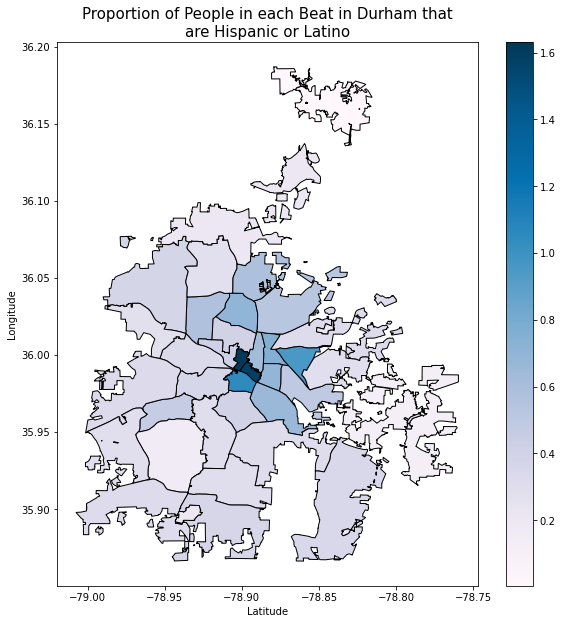

In [121]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats.plot(column='callcountperperson',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

end of checking how callcountperperson correlates with a beats popdensity

In [122]:
#putting race data into the police beat and block data
beatswithhispanics = gpd.sjoin(cblockDurhamBeats, durhamhispanicmap)
popsumbybeat = beatswithhispanics.groupby('Beat', as_index=False).sum()
hispanicsineachbeat = pd.merge(popsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
hispanicsineachbeat = hispanicsineachbeat.to_crs("EPSG:4326")
hispanicsineachbeat['prophispanic']= hispanicsineachbeat['total_hispanic_or_latino'] / hispanicsineachbeat['total']
hispanicsineachbeat

Beat_x    ALAND20  AWATER20   total  total_hispanic_or_latino  \
0      111   17579442         0   32720                      8601   
1      112   17718915         0   27224                     12345   
2      113   20482283     13325   35128                      9451   
3      114   56673958    441791   53897                     17371   
4      121  154087358   1453287   66559                     16154   
5      122   34177498     14796   42111                     17801   
6      123  102491731   1285915   92956                     30606   
7      124  427231134   2614325  145905                     11424   
8      211   57208452         0   64744                      9599   
9      212   38220261         0  107387                     12111   
10     213   46194987      7986   50588                     14804   
11     214  135818584    563391   77236                     19279   
12     221  226893769   3415686  103723                      7510   
13     222  129809040   1106477  123312                     31499   
14     223   77596501    110426   77982                     13787   
15     224  230396358   2316341  104552                     11414   
16     299  174966000  21705937    4471                       139   
17     311   50927528         0   69403                     11469   
18     312   60091447     12080   83094                     10345   
19     313   65462032    185382  102552                     14046   
20     314   50937484     39956   68356                     15332   
21     321  167331150    943307   86425                      9297   
22     322  173355145    247016  166960                     11367   
23     323  141438301   1438185   97463                     13146   
24     324  180138852   1330520   94011                      5193   
25     411   19005913     11355   38369                      4532   
26     412   62181154    155097   71852                      9143   
27     413   61569328     57053   56461                     12546   
28     414  194989635   1032004  123733                     17986   
29     415   91903149   1796107  106214                     15744   
30     421  108106949   1616800  135349                     13946   
31     422  148967926   2348774  102540                      9153   
32     423  295488212   3422861  146011                     10933   
33     511   29227231         0   44560                      3245   
34     512    7656325         0   15694                      1336   
35     513    7140807         0   18901                      2016   
36     999   15400563    125985    9616                       715   

    total_not_hispanic_or_latino  LAWBEAT  \
0                          24119      111   
1                          14879      112   
2                          25677      113   
3                          36526      114   
4                          50405      121   
5                          24310      122   
6                          62350      123   
7                         134481      124   
8                          55145      211   
9                          95276      212   
10                         35784      213   
11                         57957      214   
12                         96213      221   
13                         91813      222   
14                         64195      223   
15                         93138      224   
16                          4332      299   
17                         57934      311   
18                         72749      312   
19                         88506      313   
20                         53024      314   
21                         77128      321   
22                        155593      322   
23                         84317      323   
24                         88818      324   
25                         33837      411   
26                         62709      412   
27                         43915      413   
28                        105747      414   
29                         9047

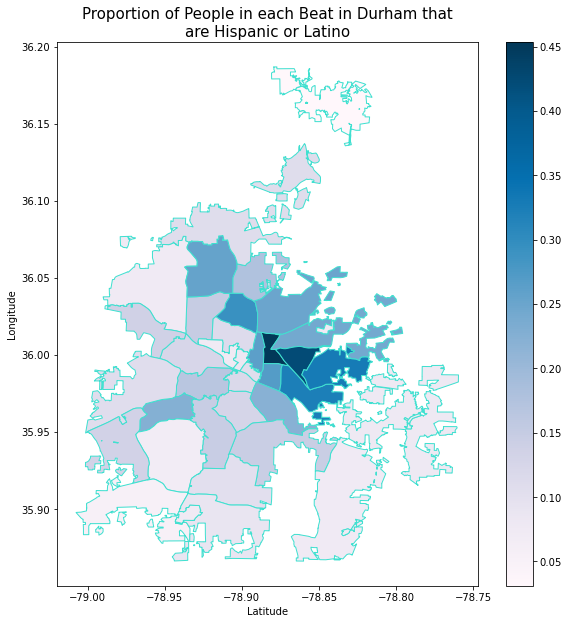

In [123]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
hispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'turquoise');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [124]:
commsafebeatswithhispanics = gpd.sjoin(cblockcommsafebeats, durhamhispanicmap)
commsafepopsumbybeat = commsafebeatswithhispanics.groupby('Beat', as_index=False).sum()
commsafehispanicsineachbeat = pd.merge(commsafepopsumbybeat, policebeats, left_on='Beat', right_on='LAWBEAT')
commsafehispanicsineachbeat = commsafehispanicsineachbeat.to_crs("EPSG:4326")
commsafehispanicsineachbeat['prophispanic']= commsafehispanicsineachbeat['total_hispanic_or_latino'] / commsafehispanicsineachbeat['total']

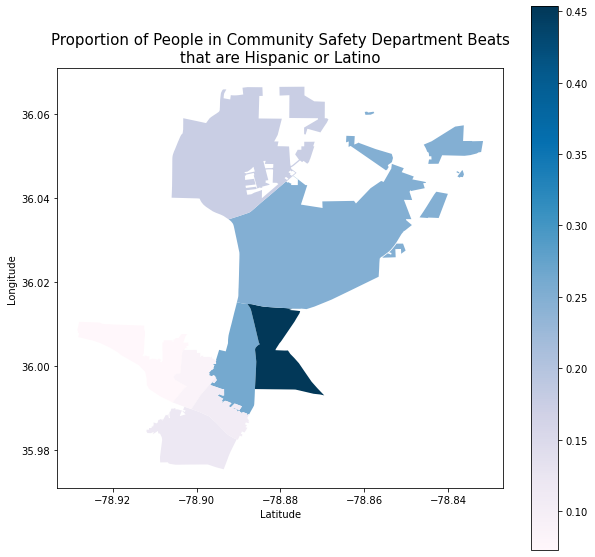

In [125]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='prophispanic',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of People in Community Safety Department Beats\nthat are Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

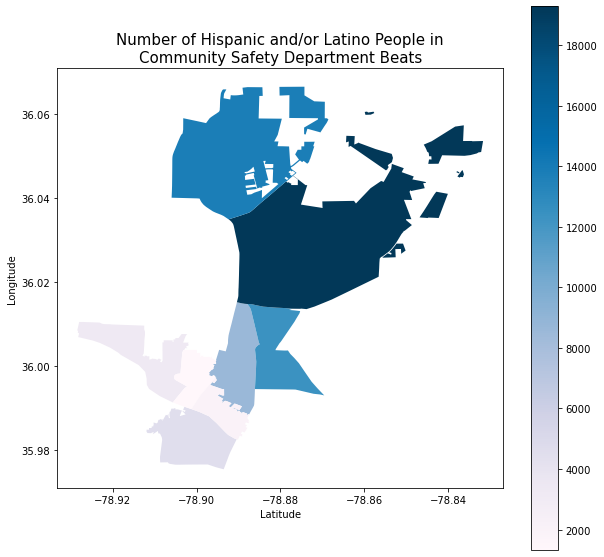

In [126]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
commsafehispanicsineachbeat.plot(column='total_hispanic_or_latino',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1);

# ax.set(title='Number of Calls by Police Beat')
plt.title("Number of Hispanic and/or Latino People in\nCommunity Safety Department Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

commsafehispanicsineachbeat = hispanics by police beat but only including the beats that the community safety department is currently working in
hispanicsineachbeat = hispanics by police beat for all police beats in durham
blockswithhispanics = hispanics by census block but only the blocks in beats that the community safety department is currently working in

In [127]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
hispanicsinnoncommsafebeat = hispanicsineachbeat[~hispanicsineachbeat.Beat_x.isin(commsafe_list)]
hispanicsinnoncommsafebeat.head()

Beat_x    ALAND20  AWATER20  total  total_hispanic_or_latino  \
2     113   20482283     13325  35128                      9451   
3     114   56673958    441791  53897                     17371   
4     121  154087358   1453287  66559                     16154   
5     122   34177498     14796  42111                     17801   
6     123  102491731   1285915  92956                     30606   

   total_not_hispanic_or_latino  LAWBEAT  \
2                         25677      113   
3                         36526      114   
4                         50405      121   
5                         24310      122   
6                         62350      123   

                                            geometry  OBJECTID     PERIMETER  \
2  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62  20667.539062   
3  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65  53321.980469   
4  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38  14495.120117   
5  POLYGON ((-78.84694 36.00614, -78.84634 36.006...        54  36686.679688   
6  MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...        55  74375.859375   

  STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre    ShapeSTLen  \
2      I        yes      D1  113       None  2.159195e+07  20667.538873   
3      I        yes      D1  114       None  6.103382e+07  53321.974873   
4      I         no      D1  121       None  7.008533e+06  14495.120026   
5      I        yes      D1  122       None  3.436298e+07  36686.681354   
6      I        yes      D1  123       None  7.495698e+07  74375.856455   

   Beat_y  id  prophispanic  
2     113   2      0.269045  
3     114   3      0.322300  
4     121   4      0.242702  
5     122   5      0.422716  
6     123   6      0.329253

In [128]:
meanpropofhispanicsnotincommsafe = hispanicsinnoncommsafebeat[["prophispanic"]].mean()
meanpropofhispanicsnotincommsafe

prophispanic    0.161637
dtype: float64

In [129]:
meanpropofhispanicsincommsafe = commsafehispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsincommsafe

prophispanic    0.190683
dtype: float64

In [130]:
meanpropofhispanicsinallbeats = hispanicsineachbeat[["prophispanic"]].mean()
meanpropofhispanicsinallbeats

prophispanic    0.167917
dtype: float64

start looking at pop data change by block oer past 10 years

In [131]:
hispanicdata2010 = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/hispanicdata2010/hispanicdata2010.csv', skiprows =1)
hispanicdata2010['GEOID20'] = hispanicdata2010['id'].str[-15:]
hispanicdata2010.drop('id', axis=1, inplace=True)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 0:25], inplace = True, axis = 1)
hispanicdata2010.drop(hispanicdata2010.iloc[:, 1:48], inplace = True, axis = 1)
#hispanicdata2010.columns = hispanicdata2010.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata2010.rename(columns = {'Total':'total2010'}, inplace = True)
hispanicdata2010

total2010                               Geographic Area Name  \
0           97  Block 1000, Block Group 1, Census Tract 1.01, ...   
1           51  Block 1001, Block Group 1, Census Tract 1.01, ...   
2           38  Block 1002, Block Group 1, Census Tract 1.01, ...   
3           47  Block 1003, Block Group 1, Census Tract 1.01, ...   
4           51  Block 1004, Block Group 1, Census Tract 1.01, ...   
...        ...                                                ...   
5024         0  Block 1124, Block Group 1, Census Tract 9801, ...   
5025         0  Block 1125, Block Group 1, Census Tract 9801, ...   
5026         0  Block 1126, Block Group 1, Census Tract 9801, ...   
5027         0  Block 1127, Block Group 1, Census Tract 9801, ...   
5028         0  Block 1128, Block Group 1, Census Tract 9801, ...   

              GEOID20  
0     370630001011000  
1     370630001011001  
2     370630001011002  
3     370630001011003  
4     370630001011004  
...               ...  
5024  370639801001124  
5025  370639801001125  
5026  370639801001126  
5027  370639801001127  
5028  370639801001128  

[5029 rows x 3 columns]

In [132]:
hispanicpopforbothyears = pd.merge(hispanicdata2010, hispanicdata, left_on='GEOID20', right_on='geoid20')
hispanicpopforbothyears['total2010'] = hispanicpopforbothyears['total2010'].astype(int)
hispanicpopforbothyears['percentpopgrowth']= hispanicpopforbothyears['total'] / hispanicpopforbothyears['total2010']
hispanicpopforbothyears

total2010                               Geographic Area Name  \
0            97  Block 1000, Block Group 1, Census Tract 1.01, ...   
1            51  Block 1001, Block Group 1, Census Tract 1.01, ...   
2            38  Block 1002, Block Group 1, Census Tract 1.01, ...   
3            47  Block 1003, Block Group 1, Census Tract 1.01, ...   
4            51  Block 1004, Block Group 1, Census Tract 1.01, ...   
...         ...                                                ...   
2249          0  Block 1068, Block Group 1, Census Tract 9801, ...   
2250          0  Block 1069, Block Group 1, Census Tract 9801, ...   
2251          0  Block 1070, Block Group 1, Census Tract 9801, ...   
2252          0  Block 1071, Block Group 1, Census Tract 9801, ...   
2253          0  Block 1072, Block Group 1, Census Tract 9801, ...   

              GEOID20                               geographic_area_name  \
0     370630001011000  Block 1000, Block Group 1, Census Tract 1.01, ...   
1     370630001011001  Block 1001, Block Group 1, Census Tract 1.01, ...   
2     370630001011002  Block 1002, Block Group 1, Census Tract 1.01, ...   
3     370630001011003  Block 1003, Block Group 1, Census Tract 1.01, ...   
4     370630001011004  Block 1004, Block Group 1, Census Tract 1.01, ...   
...               ...                                                ...   
2249  370639801001068  Block 1068, Block Group 1, Census Tract 9801, ...   
2250  370639801001069  Block 1069, Block Group 1, Census Tract 9801, ...   
2251  370639801001070  Block 1070, Block Group 1, Census Tract 9801, ...   
2252  370639801001071  Block 1071, Block Group 1, Census Tract 9801, ...   
2253  370639801001072  Block 1072, Block Group 1, Census Tract 9801, ...   

      total  total_hispanic_or_latino  total_not_hispanic_or_latino  \
0       108                        25                            83   
1        35                        12                            23   
2        38                         8                            30   
3        43                         0                            43   
4        31                         7                            24   
...     ...                       ...                           ...   
2249      0                         0                             0   
2250      0                         0                             0   
2251      0                         0                             0   
2252      0                         0                             0   
2253      0                         0                             0   

              geoid20  percentpopgrowth  
0     370630001011000          1.113402  
1     370630001011001          0.686275  
2     370630001011002          1.000000  
3     370630001011003          0.914894  
4     370630001011004          0.607843  
...               ...               ...  
2249  370639801001068               NaN  
2250  370639801001069               NaN  
2251  370639801001070               NaN  
2252  370639801001071               NaN  
2253  370639801001072               NaN  

[2254 rows x 9 columns]

In [133]:
hispanicpopforbothyears.columns

Index(['total2010', 'Geographic Area Name', 'GEOID20', 'geographic_area_name',
       'total', 'total_hispanic_or_latino', 'total_not_hispanic_or_latino',
       'geoid20', 'percentpopgrowth'],
      dtype='object')

In [134]:
percentgrowth = hispanicpopforbothyears[['GEOID20','percentpopgrowth']]
percentgrowth.head()

GEOID20  percentpopgrowth
0  370630001011000          1.113402
1  370630001011001          0.686275
2  370630001011002          1.000000
3  370630001011003          0.914894
4  370630001011004          0.607843

start looking at age

In [135]:
sexbyagedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/sexbyagedata/sexbyage.csv', skiprows =1)
sexbyagedata['GEOID10'] = sexbyagedata['id'].str[-15:]
sexbyagedata.drop('id', axis=1, inplace=True)
sexbyagedata.rename(columns = {'Total':'popcount2010'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Male':'popcountmale'}, inplace = True)
sexbyagedata.rename(columns = {'Total!!Female':'popcountfemale'}, inplace = True)
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Male!!')
sexbyagedata.columns = sexbyagedata.columns.str.lstrip('Total!!Female!!')

In [136]:
#Add duplicate column names together
sexbyagedata = sexbyagedata.sum(axis=1, level=0, skipna=False)
sexbyagedata["GEOID10"] = sexbyagedata["GEOID10"].map(str)
sexbyagedata['GEOID10'] = sexbyagedata['GEOID10'].str[:-2]

In [137]:
#Merge sexbyage with percentgrowth on geoid
#sexbyage2020 = pd.merge(percentgrowth, sexbyagedata, on = 'GEOID20')
#sexbyage2020

In [138]:
#cols_s = sexbyage2020.columns[sexbyage2020.columns.str.endswith('s')]

#for col_s in cols_s:
        #sexbyage2020['2020 ' + col_s] = sexbyage2020['percentpopgrowth'] * sexbyage2020[col_s]

#sexbyage2020['popcount2010'] = sexbyage2020['popcount2010'].astype(float)
#sexbyage2020['popcount2020'] = sexbyage2020['popcount2010'] * sexbyage2020['percentpopgrowth']
#sexbyage2020.head(1)


In [139]:
sexbyagedata['14 years and under'] = sexbyagedata['Under 5 years'] + sexbyagedata['5 to 9 years'] + sexbyagedata['10 to 14 years']
sexbyagedata['15 to 24 years'] = sexbyagedata['15 to 17 years'] + sexbyagedata['18 and 19 years'] + sexbyagedata['20 years'] + sexbyagedata['21 years'] + sexbyagedata['22 to 24 years']
sexbyagedata['25 to 39 years'] = sexbyagedata['25 to 29 years'] + sexbyagedata['30 to 34 years'] + sexbyagedata['35 to 39 years']
sexbyagedata['40 to 64 years'] = sexbyagedata['40 to 44 years'] + sexbyagedata['45 to 49 years'] + sexbyagedata['50 to 54 years'] + sexbyagedata['55 to 59 years'] + sexbyagedata['60 and 61 years'] + sexbyagedata['62 to 64 years']
sexbyagedata['65 years and over'] = sexbyagedata['65 and 66 years'] + sexbyagedata['67 to 69 years'] + sexbyagedata['70 to 74 years'] + sexbyagedata['75 to 79 years'] + sexbyagedata['80 to 84 years'] + sexbyagedata['85 years and over']
sexbyagedata

popcount2010  popcountmale  Under 5 years  5 to 9 years  10 to 14 years  \
0              97            54              9             6               7   
1              51            24              1             9               4   
2              38            23              3             3               2   
3              47            30              4             6               6   
4              51            29              2             4               1   
...           ...           ...            ...           ...             ...   
5024            0             0              0             0               0   
5025            0             0              0             0               0   
5026            0             0              0             0               0   
5027            0             0              0             0               0   
5028            0             0              0             0               0   

      15 to 17 years  18 and 19 years  20 years  21 years  22 to 24 years  \
0                  2                6         2         2               2   
1                  2                0         0         0               0   
2                  1                0         0         0               0   
3                  4                3         1         1               1   
4                  1                1         2         1               6   
...              ...              ...       ...       ...             ...   
5024               0                0         0         0               0   
5025               0                0         0         0               0   
5026               0                0         0         0               0   
5027               0                0         0         0               0   
5028               0                0         0         0               0   

      25 to 29 years  30 to 34 years  35 to 39 years  40 to 44 years  \
0                  8              10               7               5   
1                  6               5               4               5   
2                  4               9               6               2   
3                  3               4               6               3   
4                  6               2               4               7   
...              ...             ...             ...             ...   
5024               0               0               0               0   
5025               0               0               0               0   
5026               0               0               0               0   
5027               0               0               0               0   
5028               0               0               0               0   

      45 to 49 years  50 to 54 years  55 to 59 years  60 and 61 years  \
0                  8               6               7                1   
1                  2               4               2                0   
2                  1               1               4                1   
3                  1               1               2                0   
4                  4               3               3                0   
...              ...             ...             ...              ...   
5024               0               0               0                0   
5025               0               0               0                0   
5026               0               0               0                0   
5027               0               0               0                0   
5028               0               0               0                0   

      62 to 64 years  65 and 66 years  67 to 69 years  70 to 74 years  \
0                  0                1               5               1   
1                  1                0               1               1   
2                  1                0               0               0   
3                  0                1               0               0   
4           

In [140]:
sexbyagedata.drop(sexbyagedata.iloc[:, 2:25], inplace = True, axis = 1)
sexbyagedata.columns

Index(['popcount2010', 'popcountmale', 'popcountfemale',
       'Geographic Area Name', 'GEOID10', '14 years and under',
       '15 to 24 years', '25 to 39 years', '40 to 64 years',
       '65 years and over'],
      dtype='object')

In [141]:
durhamagemap = pd.merge(sexbyagedata, durhamblockmap, left_on ='GEOID10', right_on='GEOID20')
durhamagemap.drop(['MTFCC20', 'UATYPE20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'BLOCKCE20', 'TRACTCE20', 'UR20', 'UACE20', 'STATEFP20', 'NAME20'], axis=1, inplace=True)
durhamagemap['popcount2010'] = durhamagemap['popcountmale'] + durhamagemap['popcountfemale']
durhamagemap['propadults']= durhamagemap['25 to 39 years'] / durhamagemap['popcount2010']
durhamagemap['propboomers']= durhamagemap['40 to 64 years'] / durhamagemap['popcount2010']
durhamagemap['propyouth']= durhamagemap['15 to 24 years'] / durhamagemap['popcount2010']
durhamagemap['propchildren']= durhamagemap['14 years and under'] / durhamagemap['popcount2010']
durhamagemap['propseniors']= durhamagemap['65 years and over'] / durhamagemap['popcount2010']
durhamagemap

popcount2010  popcountmale  popcountfemale  \
0               97            54              43   
1               51            24              27   
2               38            23              15   
3               47            30              17   
4               51            29              22   
...            ...           ...             ...   
2249             0             0               0   
2250             0             0               0   
2251             0             0               0   
2252             0             0               0   
2253             0             0               0   

                                   Geographic Area Name          GEOID10  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...  370630001011000   
1     Block 1001, Block Group 1, Census Tract 1.01, ...  370630001011001   
2     Block 1002, Block Group 1, Census Tract 1.01, ...  370630001011002   
3     Block 1003, Block Group 1, Census Tract 1.01, ...  370630001011003   
4     Block 1004, Block Group 1, Census Tract 1.01, ...  370630001011004   
...                                                 ...              ...   
2249  Block 1068, Block Group 1, Census Tract 9801, ...  370639801001068   
2250  Block 1069, Block Group 1, Census Tract 9801, ...  370639801001069   
2251  Block 1070, Block Group 1, Census Tract 9801, ...  370639801001070   
2252  Block 1071, Block Group 1, Census Tract 9801, ...  370639801001071   
2253  Block 1072, Block Group 1, Census Tract 9801, ...  370639801001072   

      14 years and under  15 to 24 years  25 to 39 years  40 to 64 years  \
0                     22              14              25              27   
1                     14               2              15              14   
2                      8               1              19              10   
3                     16              10              13               7   
4                      7              11              12              17   
...                  ...             ...             ...             ...   
2249                   0               0               0               0   
2250                   0               0               0               0   
2251                   0               0               0               0   
2252                   0               0               0               0   
2253                   0               0               0               0   

      65 years and over COUNTYFP20          GEOID20   INTPTLAT20  \
0                     9        063  370630001011000  +36.0194814   
1                     6        063  370630001011001  +36.0205516   
2                     0        063  370630001011002  +36.0205916   
3                     1        063  370630001011003  +36.0205318   
4                     4        063  370630001011004  +36.0221289   
...                 ...        ...              ...          ...   
2249                  0        063  370639801001068  +35.8697575   
2250                  0        063  370639801001069  +35.8691012   
2251                  0        063  370639801001070  +35.8687255   
2252                  0        063  370639801001071  +35.8957583   
2253                  0        063  370639801001072  +35.9385678   

        INTPTLON20                                           geometry  \
0     -078.8821382  POLYGON ((-78.88999 36.01852, -78.88995 36.019...   
1     -078.8893121  POLYGON ((-78.88993 36.02006, -78.88990 36.021...   
2     -078.8869754  POLYGON ((-78.88749 36.02015, -78.88746 36.021...   
3     -078.8880959  POLYGON ((-78.88872 36.01988, -78.88867 36.021...   
4     -078.8796703  POLYGON ((-78.88098 36.02211, -78.87993 36.022...   
...            ...                                                ...   
2249  -078.8648679  POLYGON ((-78.86527 35.87076, -78.86499 35.870...   
2250  -078.8652956  POLYGON ((-78.86569 35.87062, -78.86540 35.870...   
2251  -078.8673419  POLYGON ((-78.87004 35.86799, -78.86978 35.868...   
2252  -0

In [142]:
meanadultprop = durhamagemap[["propadults"]].mean()
meanadultprop

propadults    0.238455
dtype: float64

In [143]:
meanboomerprop = durhamagemap[["propboomers"]].mean()
meanboomerprop

propboomers    0.343124
dtype: float64

In [144]:
meanyouthprop = durhamagemap[["propyouth"]].mean()
meanyouthprop

propyouth    0.118396
dtype: float64

In [145]:
meanchildrenprop = durhamagemap[["propchildren"]].mean()
meanchildrenprop

propchildren    0.177689
dtype: float64

In [146]:
meanseniorprop = durhamagemap[["propseniors"]].mean()
meanseniorprop

propseniors    0.122337
dtype: float64

In [147]:
durham2010blockmap = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/2010durhamblocksshapefile/tl_2010_37063_tabblock10.shp')
durham2010blockmap = durham2010blockmap.to_crs("EPSG:4326")

In [148]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durham2010blockmap.index:
    cblock_geom = durham2010blockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats2010 = durham2010blockmap[durham2010blockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats2010['Beat'] = cblockDurhamBeats2010.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

start of checking how callcountperperson correlates with proportion of people that are "youth"

In [149]:
agedataindurhambyblocks = pd.merge(cblockDurhamBeats2010, sexbyagedata, on ='GEOID10')
agesumbybeat = agedataindurhambyblocks.groupby('Beat', as_index=False).sum()
agesumbybeat['popcount2010'] = agesumbybeat['popcountmale'] + agesumbybeat['popcountfemale']
agesumbybeat['propfemale'] = agesumbybeat['popcountfemale'] / agesumbybeat['popcount2010']
agesumbybeat['propmale'] = agesumbybeat['popcountmale'] / agesumbybeat['popcount2010']
agesumbybeat.drop('popcountmale', axis=1, inplace=True)
agesumbybeat.drop('popcountfemale', axis=1, inplace=True)
agesumbybeat.drop('AWATER10', axis=1, inplace=True)
agesumbybeat.drop('ALAND10', axis=1, inplace=True)
agesumbybeat

Beat  14 years and under  15 to 24 years  25 to 39 years  40 to 64 years  \
0    111                 843             562             943            1147   
1    112                 706             408             720             810   
2    113                 770             509             730             997   
3    114                1372             799            1314            1552   
4    121                1845             852            1886            1775   
5    122                 833             490             768             731   
6    123                2062            1167            1943            2386   
7    124                1374             551            1805            2044   
8    211                 847             534            1556            1721   
9    212                1420            1013            2622            2379   
10   213                1017             669            1451            1358   
11   214                1422             892            1273            1977   
12   221                1354             747            1407            3079   
13   222                2330            1439            2846            3052   
14   223                1613             946            1418            1459   
15   224                2293            1037            1914            4241   
16   299                 100              63             117             270   
17   311                1211             652            1564            2146   
18   312                 849            4346            1442            1014   
19   313                1519            2260            3389            2159   
20   314                1335             975            2160            1495   
21   321                1565            1020            1950            2555   
22   322                2490            1291            3983            5056   
23   323                1042            1386            2597            1883   
24   324                1388            1011            2942            2228   
25   411                 468             315             444             833   
26   412                1074            2771             918            1583   
27   413                1236             670             830            1307   
28   414                1377            1427            2366            1712   
29   415                1688             902            2073            2637   
30   421                1969            1571            4319            2801   
31   422                2283             947            2640            3350   
32   423                1587             974            3508            2193   
33   511                  92            2320             954             354   
34   512                  19             213             300             224   
35   513                 262             144             233             328   
36   999                  56              19              50              78   

    65 years and over  popcount2010  propfemale  propmale  
0                 291          3786    0.488906  0.511094  
1                 184          2828    0.488685  0.511315  
2                 183          3189    0.463468  0.536532  
3                 389          5426    0.537044  0.462956  
4                 316          6674    0.535211  0.464789  
5                 221          3043    0.493263  0.506737  
6                 388          7946    0.527939  0.472061  
7                 412          6186    0.515842  0.484158  
8                 486          5144    0.519246  0.480754  
9                 476          7910    0.495070  0.504930  
10                549          5044    0.520619  0.479381  
11                520          6084    0.522682  0.477318  
12               1921          8508    0.536906  0.463094  
13                935         10602    0.527919  0.472081  
14                527          5963    0.578065  0.421935  
15 

In [150]:
agesumbybeat['popcount2010'].sum()

234898

In [151]:
#agesumbybeat = agesumbybeat.set_crs("EPSG:4326")
#agesumbybeat = agesumbybeat.to_crs("EPSG:4326")

In [152]:
beats_callcount_agedata = pd.merge(beats_callcount_popdata, agesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_agedata['callcountperperson']= beats_callcount_agedata['calls_count'] / beats_callcount_agedata['total']
beats_callcount_agedata['propadults']= beats_callcount_agedata['25 to 39 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propboomers']= beats_callcount_agedata['40 to 64 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propyouth']= beats_callcount_agedata['15 to 24 years'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propchildren']= beats_callcount_agedata['14 years and under'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata['propseniors']= beats_callcount_agedata['65 years and over'] / beats_callcount_agedata['popcount2010']
beats_callcount_agedata

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
5       122      54.0   36686.679688  3.436298e+07   36686.681354      122.0   
6       123      55.0   74375.859375  7.495698e+07   74375.856455      123.0   
7       124      63.0   10708.070312  3.022588e+06   10708.070450      124.0   
8       211      36.0   36748.878906  6.487864e+07   36748.875052      211.0   
9       212      43.0   37127.789062  4.301152e+07   37127.786492      212.0   
10      213      37.0   28560.539062  4.691512e+07   28560.540431      213.0   
11      214      23.0    1715.291016  1.329736e+05    1715.290848      214.0   
12      221      17.0   87384.078125  2.027947e+08   87384.076005      221.0   
13      222      16.0   50498.308594  1.066247e+08   50498.309761      222.0   
14      223      21.0   16095.400391  6.891411e+06   16095.395041      223.0   
15      224      12.0   94210.453125  7.014559e+07   94210.453140      224.0   
16      299       1.0   29657.869141  2.075708e+07   29657.868615      299.0   
17      311      66.0   48409.859375  6.081916e+07   48409.861058      311.0   
18      312      52.0   42676.800781  6.884782e+07   42676.796572      312.0   
19      313      39.0   57403.839844  6.812116e+07   57403.841356      313.0   
20      314      78.0   38782.281250  5.416068e+07   38782.281943      314.0   
21      321      58.0  122575.601562  1.593645e+08  122575.571649      321.0   
22      322      87.0   60429.371094  1.639988e+08   60429.372056      322.0   
23      323      80.0   74252.812500  1.066631e+08   74252.813082      323.0   
24      324     106.0  128371.601562  1.523746e+08  128371.584023      324.0   
25      411      67.0   24141.640625  2.140812e+07   24141.641318      411.0   
26      412      75.0   33732.519531  5.757125e+07   33732.518542      412.0   
27      413      71.0   45203.929688  6.563018e+07   45203.932226      413.0   
28      414      88.0   98360.617188  1.342096e+08   98360.616926      414.0   
29      415      79.0   60313.781250  8.843634e+07   60313.778960      415.0   
30      421      99.0   58692.320312  1.180636e+08   58692.323104      421.0   
31      422     108.0  119968.398438  1.364002e+08  119968.366828      422.0   
32      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
33      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
34      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
35      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
36      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  144556.454178  2.124067e+07  2.032488e+06  817873.029067        0.0   
1    1.0  141814.763496  2.123627e+07  2.035512e+06  818871.362039        0.0   
2    2.0  139624.402959  2.123224e+07  2.035223e+06  814263.195844        0.0   
3    3.0  140596.262032  2.123422e+07  2.040281e+06  812064.585383        0.0   
4    4.0  143320.079359  2.123890e+07  2.045828e+06  824005.007615        0.0   
5    5.0  143562.447557  2.123929e+07  2.039433e+06  817595.542997        0.0   
6    6.0  144876.994257  2.124150e+07  2.046093e+06  815364.300536        0.0   
7    7.0  144959.805145  2.124171e+07  2.058114e+06  802758.864806        0.0   
8    8.0  138694.192452  2.123069e+07  2.022369e+06  828201.705835        0.0   
9    9.0  141527.279760  2.123573e+07  2.027481e+06  823625.628039        0.0   
10  10.0  152831.835538  2.125491e+07  2.029096e+06  829503.438758      

In [153]:
column_1 = beats_callcount_agedata["propseniors"]
column_2 = beats_callcount_agedata["callcountperperson"]
correlation = column_1.corr(column_2)
correlation

-0.17502010437792984

end of checking how callcountperperson correlates with proportion of people that are "youth"

In [154]:
isolating3columns = beats_callcount_agedata[['propyouth', 'propseniors']]
filtered_df = isolating3columns[isolating3columns['propyouth'].notnull()]
filtered_df = filtered_df[filtered_df['propseniors'].notnull()]
filtered_df

propyouth  propseniors
0    0.148442     0.076862
1    0.144272     0.065064
2    0.159611     0.057385
3    0.147254     0.071692
4    0.127660     0.047348
5    0.161025     0.072626
6    0.146866     0.048830
7    0.089072     0.066602
8    0.103810     0.094479
9    0.128066     0.060177
10   0.132633     0.108842
11   0.146614     0.085470
12   0.087800     0.225787
13   0.135729     0.088191
14   0.158645     0.088378
15   0.093314     0.146495
16   0.097072     0.152542
17   0.104537     0.106461
18   0.551873     0.028444
19   0.229093     0.054536
20   0.153278     0.062254
21   0.120696     0.161046
22   0.089678     0.109475
23   0.188034     0.062814
24   0.121398     0.091138
25   0.134673     0.119282
26   0.383423     0.121904
27   0.147382     0.110647
28   0.193334     0.067606
29   0.108322     0.123334
30   0.137349     0.068019
31   0.094994     0.075133
32   0.113032     0.041198
33   0.591384     0.051746
34   0.277344     0.015625
35   0.129730     0.128829
36   0.069343     0.259124

In [155]:
X = filtered_df.iloc[:, 0].values.reshape(-1, 1)
Y = filtered_df.iloc[:, 1].values.reshape(-1, 1)
#lr = LinearRegression()
#lr.fit(X, Y)
#Y_pred = lr.predict(X)

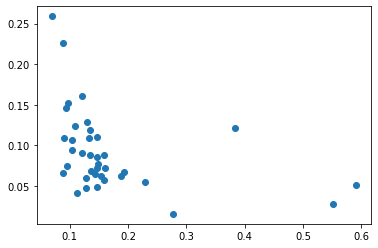

In [156]:
plt.scatter(X, Y)
#plt.plot(X, Y_pred, color = 'red')
plt.show()

In [157]:
X_mean = np.mean(X)
Y_mean = np.mean(Y)

num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
m = num / den
c = Y_mean - m*X_mean

print(m, c)

[-0.1718508] [0.12085715]


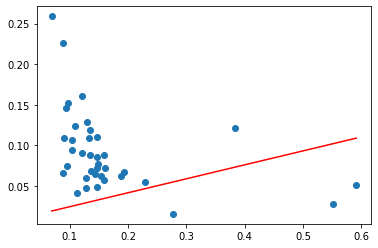

In [158]:
# Making predictions
Y_pred = m*X + c

plt.scatter(X, Y) # actual data
plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='red') # predicted
plt.show() 

start looking at household income data

In [159]:
ncblockgroupmap = gpd.read_file('/Users/erikrobertsson/Documents/dataplus/2015blockgroupshapefile/tl_2015_37_bg.shp')
ncblockgroupmap = ncblockgroupmap.to_crs("EPSG:4326")
ncblockgroupmap.head(1)

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      37      021  002401        2  370210024012  Block Group 2  G5030   

  FUNCSTAT     ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  15365558       0  +35.5219587  -082.7467767   

                                            geometry  
0  POLYGON ((-82.78041 35.52550, -82.78006 35.525...

In [160]:
durhamblockgroupmap = ncblockgroupmap[ncblockgroupmap["COUNTYFP"]=="063"]

In [161]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockgroupmap.index:
    cblock_geom = durhamblockgroupmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeatsbg = ncblockgroupmap[ncblockgroupmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeatsbg['Beat'] = cblockDurhamBeatsbg.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

In [162]:
householdincomedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/householdincomedata/householdincome.csv', skiprows =1)
householdincomedata['GEOID'] = householdincomedata['id'].str[-12:]
householdincomedata.drop('id', axis=1, inplace=True)
householdincomedata = householdincomedata.drop(householdincomedata.filter(regex='Margin').columns, axis=1)
householdincomedata = householdincomedata.drop(householdincomedata.filter(regex='Not computed').columns, axis=1)
householdincomedata = householdincomedata.drop(householdincomedata.filter(regex='30.0 percent').columns, axis=1)
householdincomedata.rename(columns=lambda s: s.replace("Estimate!!Total", "Total"), inplace=True)
householdincomedata.rename(columns=lambda s: s.replace("!!", " "), inplace=True)
householdincomedata.rename(columns = {'Total':'Total Homeowners'}, inplace = True)
householdincomedata = householdincomedata[['GEOID', 'Geographic Area Name', 'Total Homeowners', 'Total Less than $10,000', 'Total $10,000 to $19,999', 'Total $20,000 to $34,999', 'Total $35,000 to $49,999', 'Total $50,000 to $74,999', 'Total $75,000 to $99,999', 'Total $100,000 or more']]

In [163]:
incomedataindurhambyblocks = pd.merge(cblockDurhamBeatsbg, householdincomedata, left_on ='GEOID', right_on='GEOID')
incomedataindurhambyblocks.drop(['MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'TRACTCE', 'STATEFP'], axis=1, inplace=True)

In [164]:
incomesumbybeat = incomedataindurhambyblocks.groupby('Beat', as_index=False).sum()
incomesumbybeat['0to20']= incomesumbybeat['Total Less than $10,000'] + incomesumbybeat['Total $10,000 to $19,999']
incomesumbybeat['20to50']= incomesumbybeat['Total $20,000 to $34,999'] + incomesumbybeat['Total $35,000 to $49,999'] 
incomesumbybeat['50to75']= incomesumbybeat['Total $50,000 to $74,999'] 
incomesumbybeat['75to100']= incomesumbybeat['Total $75,000 to $99,999']
incomesumbybeat['100plus']= incomesumbybeat['Total $100,000 or more']
incomesumbybeat['prop_0to20']= incomesumbybeat['0to20'] / incomesumbybeat['Total Homeowners']
incomesumbybeat['prop_20to50']= incomesumbybeat['20to50'] / incomesumbybeat['Total Homeowners']
incomesumbybeat['prop_50to75']= incomesumbybeat['50to75'] / incomesumbybeat['Total Homeowners']
incomesumbybeat['prop_75to100']= incomesumbybeat['75to100'] / incomesumbybeat['Total Homeowners']
incomesumbybeat['prop_100plus']= incomesumbybeat['100plus'] / incomesumbybeat['Total Homeowners']

In [165]:
incomesumbybeat['Total Homeowners'].sum()

54256

In [166]:
beats_callcount_popdata_income = pd.merge(beats_callcount_popdata, incomesumbybeat, left_on ='LAWBEAT', right_on='Beat')

In [167]:
mappingdatasetforpolicebeats_w_income = pd.merge(policebeats, beats_callcount_popdata_income, on ='LAWBEAT')
mappingdatasetforpolicebeats_w_income

LAWBEAT                                           geometry  OBJECTID_x  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...          50   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...          51   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...          62   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...          65   
4       121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...          38   
5       122  POLYGON ((-78.84694 36.00614, -78.84634 36.006...          54   
6       123  MULTIPOLYGON (((-78.83723 36.00399, -78.83722 ...          55   
7       124  MULTIPOLYGON (((-78.77636 35.92139, -78.77722 ...          63   
8       211  POLYGON ((-78.91430 36.04098, -78.91427 36.040...          36   
9       212  POLYGON ((-78.90513 36.01904, -78.90330 36.019...          43   
10      213  POLYGON ((-78.90597 36.04011, -78.89989 36.039...          37   
11      214  MULTIPOLYGON (((-78.85254 36.02879, -78.85254 ...          23   
12      221  MULTIPOLYGON (((-78.93799 36.07698, -78.93629 ...          17   
13      222  POLYGON ((-78.91508 36.07716, -78.91321 36.077...          16   
14      223  MULTIPOLYGON (((-78.89380 36.06589, -78.89372 ...          21   
15      224  MULTIPOLYGON (((-78.91391 36.09652, -78.91391 ...          12   
16      311  POLYGON ((-78.91431 35.99170, -78.91414 35.991...          66   
17      312  POLYGON ((-78.94410 36.00873, -78.94413 36.008...          52   
18      313  POLYGON ((-78.98695 36.02959, -78.98696 36.029...          39   
19      314  POLYGON ((-78.93749 35.97542, -78.93679 35.975...          78   
20      321  MULTIPOLYGON (((-78.95996 35.99931, -78.95996 ...          58   
21      322  POLYGON ((-78.94765 35.95837, -78.94637 35.958...          87   
22      323  MULTIPOLYGON (((-78.98079 35.92612, -78.97989 ...          80   
23      324  MULTIPOLYGON (((-78.99154 35.88848, -78.99154 ...         106   
24      411  POLYGON ((-78.90125 35.98965, -78.89941 35.988...          67   
25      412  POLYGON ((-78.90870 35.97692, -78.90816 35.976...          75   
26      413  POLYGON ((-78.89017 35.98233, -78.88961 35.982...          71   
27      414  MULTIPOLYGON (((-78.87649 35.95794, -78.87636 ...          88   
28      415  POLYGON ((-78.91521 35.97136, -78.91519 35.971...          79   
29      421  POLYGON ((-78.90852 35.93573, -78.90823 35.935...          99   
30      422  MULTIPOLYGON (((-78.93721 35.87524, -78.93699 ...         108   
31      423  MULTIPOLYGON (((-78.83466 35.94599, -78.83463 ...          95   
32      511  POLYGON ((-78.92318 36.01031, -78.92260 36.010...          53   
33      512  POLYGON ((-78.90313 36.00376, -78.90298 36.003...          57   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...          61   

      PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
0    28608.800781      I        yes      D1  111       None  2.010252e+07   
1    26265.849609      I        yes      D1  112       None  2.079934e+07   
2    20667.539062      I        yes      D1  113       None  2.159195e+07   
3    53321.980469      I        yes      D1  114       None  6.103382e+07   
4    14495.120117      I         no      D1  121       None  7.008533e+06   
5    36686.679688      I        yes      D1  122       None  3.436298e+07   
6    74375.859375      I        yes      D1  123       None  7.495698e+07   
7    10708.070312      I         no      D1  124       None  3.022588e+06   
8    36748.878906      I        yes      D2  211       None  6.487864e+07   
9    37127.789062      I        yes      D2  212       None  4.301152e+07   
10   28560.539062      I        yes      D2  213       None  4.691512e+07   
11    1715.291016      I         no      D2  214       None  1.329736e+05   
12   87384.078125      I        yes      D2  221       None  2.027947e+08   
13   50498.308594      I        yes      D2  222       None  1.066247e+08   
14   16095.400391      I         no     

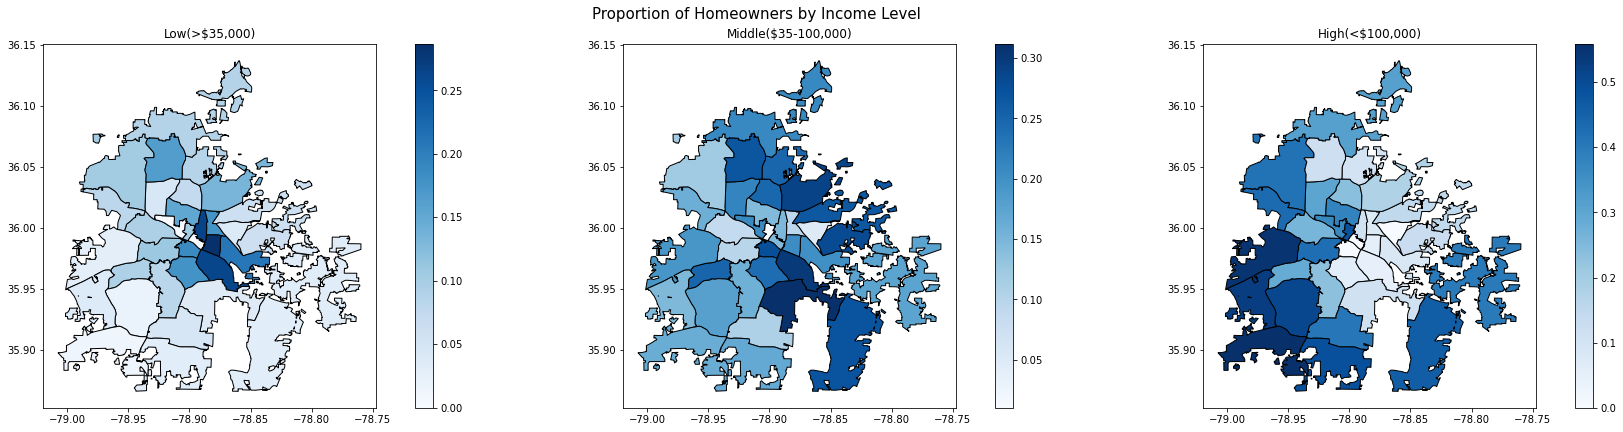

In [168]:
#Plot subplots of income
fig = plt.figure(constrained_layout=True, figsize=(24, 16))

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('Low(>$35,000)')
ax2.title.set_text('Middle($35-100,000)')
ax3.title.set_text('High(<$100,000)')

# Set figure title
fig.suptitle("Proportion of Homeowners by Income Level", fontsize = 15)

#Plot subplots
mappingdatasetforpolicebeats_w_income.plot(column='prop_0to20',
                                legend=True,
                                cmap="Blues", ax=ax1, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_income.plot(column='prop_50to75',
                                legend=True,
                                cmap="Blues", ax=ax2, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_income.plot(column='prop_100plus',
                                legend=True,
                                cmap="Blues", ax=ax3, aspect=1, edgecolor='black');

plt.show()

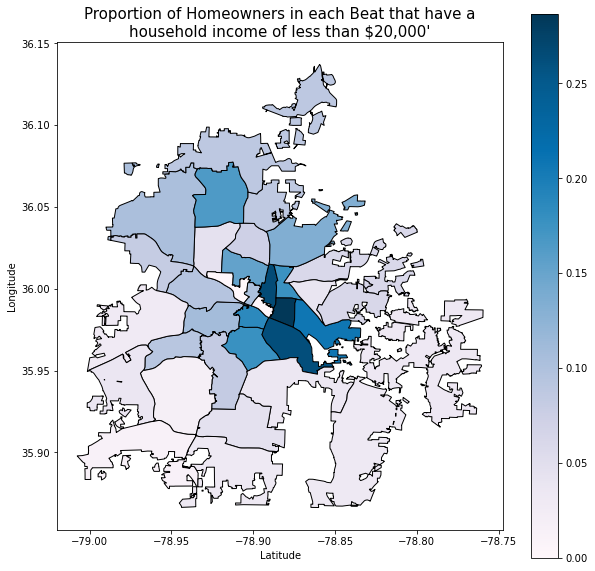

In [169]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_income.plot(column='prop_0to20',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Homeowners in each Beat that have a\nhousehold income of less than $20,000'", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

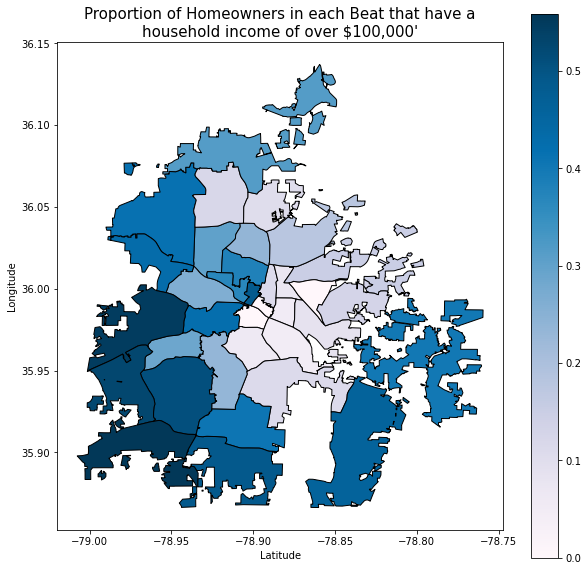

In [170]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_income.plot(column='prop_100plus',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Homeowners in each Beat that have a\nhousehold income of over $100,000'", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

end of looking at household income data

start looking at household type data

In [171]:
householdtypedata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/household_type/householdtypedata.csv', skiprows =1)
householdtypedata['GEOID10'] = householdtypedata['id'].str[-15:]
householdtypedata.drop('id', axis=1, inplace=True)
householdtypedata.rename(columns=lambda s: s.replace("!!", " "), inplace=True)
householdtypedata.rename(columns = {'Total Family households Other family Female householder, no husband present':'Total Single Mother Households'}, inplace = True)
householdtypedata.rename(columns = {'Total Family households Other family Male householder, no wife present':'Total Single Father Households'}, inplace = True)
householdtypedata.rename(columns = {'Total Family households Other family':'Total Single Parent Households'}, inplace = True)
householdtypedata.rename(columns = {'Total':'Total Households'}, inplace = True)
householdtypedata = householdtypedata[['GEOID10', 'Geographic Area Name', 'Total Households', 'Total Family households', 'Total Family households Husband-wife family', 'Total Single Parent Households', 'Total Single Father Households', 'Total Single Mother Households', 'Total Nonfamily households', 'Total Nonfamily households Householder living alone', 'Total Nonfamily households Householder not living alone']]
householdtypedata

GEOID10                               Geographic Area Name  \
0     370630001011000  Block 1000, Block Group 1, Census Tract 1.01, ...   
1     370630001011001  Block 1001, Block Group 1, Census Tract 1.01, ...   
2     370630001011002  Block 1002, Block Group 1, Census Tract 1.01, ...   
3     370630001011003  Block 1003, Block Group 1, Census Tract 1.01, ...   
4     370630001011004  Block 1004, Block Group 1, Census Tract 1.01, ...   
...               ...                                                ...   
5024  370639801001124  Block 1124, Block Group 1, Census Tract 9801, ...   
5025  370639801001125  Block 1125, Block Group 1, Census Tract 9801, ...   
5026  370639801001126  Block 1126, Block Group 1, Census Tract 9801, ...   
5027  370639801001127  Block 1127, Block Group 1, Census Tract 9801, ...   
5028  370639801001128  Block 1128, Block Group 1, Census Tract 9801, ...   

      Total Households  Total Family households  \
0                   34                       19   
1                   18                       12   
2                   15                        7   
3                   10                       10   
4                   17                        8   
...                ...                      ...   
5024                 0                        0   
5025                 0                        0   
5026                 0                        0   
5027                 0                        0   
5028                 0                        0   

      Total Family households Husband-wife family  \
0                                               7   
1                                               8   
2                                               3   
3                                               5   
4                                               6   
...                                           ...   
5024                                            0   
5025                                            0   
5026                                            0   
5027                                            0   
5028                                            0   

      Total Single Parent Households  Total Single Father Households  \
0                                 12                               3   
1                                  4                               1   
2                                  4                               2   
3                                  5                               1   
4                                  2                               1   
...                              ...                             ...   
5024                               0                               0   
5025                               0                               0   
5026                               0                               0   
5027                               0                               0   
5028                               0                               0   

      Total Single Mother Households  Total Nonfamily households  \
0                                  9                          15   
1                                  3                           6   
2                                  2                           8   
3                                  4                           0   
4                                  1                           9   
...                              ...                         ...   
5024                               0                           0   
5025                               0                           0   
5026                               0                           0   
5027                               0                           0   
5028                               0                           0   

      Total Nonfamily households Householder living alone  \
0                                                    10     
1                                              

In [172]:
householddatadurhambyblocks = pd.merge(cblockDurhamBeats2010, householdtypedata, left_on ='GEOID10', right_on='GEOID10')
householddatadurhambyblocks.rename(columns = {'GEOID10':'GEOID20'}, inplace = True)
householddatadurhambyblocks.drop(['MTFCC10', 'TRACTCE10', 'UR10', 'BLOCKCE10', 'UACE10', 'UATYP10', 'COUNTYFP10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'STATEFP10'], axis=1, inplace=True)
householddatadurhambyblocks

GEOID20      NAME10   INTPTLAT10    INTPTLON10  \
0     370630016031018  Block 1018  +36.0694104  -078.9200663   
1     370630016041028  Block 1028  +36.0782907  -078.9332672   
2     370630016043021  Block 3021  +36.0868211  -078.9419316   
3     370630016032046  Block 2046  +36.0781388  -078.9201773   
4     370630016032022  Block 2022  +36.0852214  -078.9153808   
...               ...         ...          ...           ...   
3902  370630016041036  Block 1036  +36.0729066  -078.9380765   
3903  370630021002087  Block 2087  +36.1589028  -078.8243238   
3904  370630021001007  Block 1007  +36.1481586  -078.8350039   
3905  370630021001073  Block 1073  +36.1328530  -078.8616166   
3906  370630021001087  Block 1087  +36.1144463  -078.8649878   

                                               geometry  Beat  \
0     POLYGON ((-78.92311 36.07011, -78.92247 36.070...   222   
1     POLYGON ((-78.93112 36.07878, -78.93093 36.078...   224   
2     POLYGON ((-78.94183 36.08576, -78.94201 36.085...   224   
3     POLYGON ((-78.92013 36.07900, -78.91988 36.078...   224   
4     POLYGON ((-78.91567 36.08588, -78.91565 36.085...   224   
...                                                 ...   ...   
3902  POLYGON ((-78.94155 36.07015, -78.94154 36.070...   221   
3903  POLYGON ((-78.82664 36.15457, -78.82647 36.154...   299   
3904  POLYGON ((-78.84532 36.15934, -78.84511 36.159...   299   
3905  POLYGON ((-78.85798 36.13275, -78.85939 36.134...   224   
3906  POLYGON ((-78.86383 36.11493, -78.86367 36.114...   224   

                                   Geographic Area Name  Total Households  \
0     Block 1018, Block Group 1, Census Tract 16.03,...                 0   
1     Block 1028, Block Group 1, Census Tract 16.04,...                33   
2     Block 3021, Block Group 3, Census Tract 16.04,...                22   
3     Block 2046, Block Group 2, Census Tract 16.03,...                10   
4     Block 2022, Block Group 2, Census Tract 16.03,...                 0   
...                                                 ...               ...   
3902  Block 1036, Block Group 1, Census Tract 16.04,...                 0   
3903  Block 2087, Block Group 2, Census Tract 21, Du...                 0   
3904  Block 1007, Block Group 1, Census Tract 21, Du...                 5   
3905  Block 1073, Block Group 1, Census Tract 21, Du...                16   
3906  Block 1087, Block Group 1, Census Tract 21, Du...                 0   

      Total Family households  Total Family households Husband-wife family  \
0                           0                                            0   
1                          20                                           15   
2                          20                                           15   
3                           8                                            7   
4                           0                                            0   
...                       ...                                          ...   
3902                        0                                            0   
3903                        0                                            0   
3904                        3                                            2   
3905                       16                                           16   
3906                        0                                            0   

      Total Single Parent Households  Total Single Father Households  \
0                                  0                               0   
1                                  5                               0   
2                                  5                               0   
3                                  1                               0   
4                                  0                               0   
...                              ...                             ...   
3902                               0                               0   
3903                      

In [173]:
householdtypesumbybeat = householddatadurhambyblocks.groupby('Beat', as_index=False).sum()

In [174]:
householdtypesumbybeat['Total Households'].sum()

96040

In [175]:
beats_callcount_pop_age_householdtype = pd.merge(beats_callcount_agedata, householdtypesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_pop_age_householdtype['propsingleparent']= beats_callcount_pop_age_householdtype['Total Single Parent Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propsinglemom']= beats_callcount_pop_age_householdtype['Total Single Mother Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propsinglefather']= beats_callcount_pop_age_householdtype['Total Single Father Households'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['propfamilyhouseholds']= beats_callcount_pop_age_householdtype['Total Family households'] / beats_callcount_pop_age_householdtype['Total Households']
beats_callcount_pop_age_householdtype['proptwoparent']= beats_callcount_pop_age_householdtype['Total Family households Husband-wife family'] / beats_callcount_pop_age_householdtype['Total Family households']
beats_callcount_pop_age_householdtype['householdsdensity']= beats_callcount_pop_age_householdtype['Total Households'] / beats_callcount_pop_age_householdtype['area']
beats_callcount_pop_age_householdtype

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
5       122      54.0   36686.679688  3.436298e+07   36686.681354      122.0   
6       123      55.0   74375.859375  7.495698e+07   74375.856455      123.0   
7       124      63.0   10708.070312  3.022588e+06   10708.070450      124.0   
8       211      36.0   36748.878906  6.487864e+07   36748.875052      211.0   
9       212      43.0   37127.789062  4.301152e+07   37127.786492      212.0   
10      213      37.0   28560.539062  4.691512e+07   28560.540431      213.0   
11      214      23.0    1715.291016  1.329736e+05    1715.290848      214.0   
12      221      17.0   87384.078125  2.027947e+08   87384.076005      221.0   
13      222      16.0   50498.308594  1.066247e+08   50498.309761      222.0   
14      223      21.0   16095.400391  6.891411e+06   16095.395041      223.0   
15      224      12.0   94210.453125  7.014559e+07   94210.453140      224.0   
16      299       1.0   29657.869141  2.075708e+07   29657.868615      299.0   
17      311      66.0   48409.859375  6.081916e+07   48409.861058      311.0   
18      312      52.0   42676.800781  6.884782e+07   42676.796572      312.0   
19      313      39.0   57403.839844  6.812116e+07   57403.841356      313.0   
20      314      78.0   38782.281250  5.416068e+07   38782.281943      314.0   
21      321      58.0  122575.601562  1.593645e+08  122575.571649      321.0   
22      322      87.0   60429.371094  1.639988e+08   60429.372056      322.0   
23      323      80.0   74252.812500  1.066631e+08   74252.813082      323.0   
24      324     106.0  128371.601562  1.523746e+08  128371.584023      324.0   
25      411      67.0   24141.640625  2.140812e+07   24141.641318      411.0   
26      412      75.0   33732.519531  5.757125e+07   33732.518542      412.0   
27      413      71.0   45203.929688  6.563018e+07   45203.932226      413.0   
28      414      88.0   98360.617188  1.342096e+08   98360.616926      414.0   
29      415      79.0   60313.781250  8.843634e+07   60313.778960      415.0   
30      421      99.0   58692.320312  1.180636e+08   58692.323104      421.0   
31      422     108.0  119968.398438  1.364002e+08  119968.366828      422.0   
32      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
33      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
34      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
35      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
36      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  144556.454178  2.124067e+07  2.032488e+06  817873.029067        0.0   
1    1.0  141814.763496  2.123627e+07  2.035512e+06  818871.362039        0.0   
2    2.0  139624.402959  2.123224e+07  2.035223e+06  814263.195844        0.0   
3    3.0  140596.262032  2.123422e+07  2.040281e+06  812064.585383        0.0   
4    4.0  143320.079359  2.123890e+07  2.045828e+06  824005.007615        0.0   
5    5.0  143562.447557  2.123929e+07  2.039433e+06  817595.542997        0.0   
6    6.0  144876.994257  2.124150e+07  2.046093e+06  815364.300536        0.0   
7    7.0  144959.805145  2.124171e+07  2.058114e+06  802758.864806        0.0   
8    8.0  138694.192452  2.123069e+07  2.022369e+06  828201.705835        0.0   
9    9.0  141527.279760  2.123573e+07  2.027481e+06  823625.628039        0.0   
10  10.0  152831.835538  2.125491e+07  2.029096e+06  829503.438758      

In [176]:
#Create a new table for callsperperson for every beat
highestsingleparent = beats_callcount_pop_age_householdtype[['propsingleparent', 'LAWBEAT']].copy()
highestsingleparent.sort_values(by='propsingleparent', inplace=True, ascending=False)
topten_singleparents = highestsingleparent.iloc[0:10].copy()
topten_singleparents

propsingleparent  LAWBEAT
35          0.765766      513
25          0.681818      411
27          0.661164      413
2           0.622875      113
26          0.612245      412
0           0.605744      111
14          0.592086      223
5           0.588757      122
1           0.575175      112
3           0.546485      114

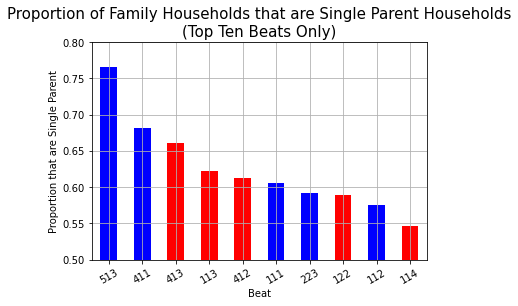

In [177]:
#Create a bar plot with callsperperson
toptennoncommsafe_list = [122, 413, 412, 113, 114]
color = ["red" if i in toptennoncommsafe_list else "blue" for i in topten_singleparents['LAWBEAT']]
topten_singleparents.plot.bar(y = 'propsingleparent', x = 'LAWBEAT', color=color, legend=False, grid=True)

plt.xticks(rotation=30, horizontalalignment="center")

plt.title("Proportion of Family Households that are Single Parent Households\n(Top Ten Beats Only)", fontsize = 15)

plt.ylim(0.5, 0.8)

plt.xlabel("Beat")

plt.ylabel("Proportion that are Single Parent")

plt.show()

In [178]:
mappingdatasetforpolicebeats_w_householdtype = pd.merge(policebeats, beats_callcount_pop_age_householdtype, on ='LAWBEAT')
mappingdatasetforpolicebeats_w_householdtype.sort_values(by='propsingleparent', inplace=True, ascending=False)
mappingdatasetforpolicebeats_w_householdtype.head(10)

LAWBEAT                                           geometry  OBJECTID_x  \
35      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...          61   
25      411  POLYGON ((-78.90125 35.98965, -78.89941 35.988...          67   
27      413  POLYGON ((-78.89017 35.98233, -78.88961 35.982...          71   
2       113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...          62   
26      412  POLYGON ((-78.90870 35.97692, -78.90816 35.976...          75   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...          50   
14      223  MULTIPOLYGON (((-78.89380 36.06589, -78.89372 ...          21   
5       122  POLYGON ((-78.84694 36.00614, -78.84634 36.006...          54   
1       112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...          51   
3       114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...          65   

     PERIMETER_x STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1  ShapeSTAre_x  \
35  20647.179688      I        yes      D5  513       None  9.114313e+06   
25  24141.640625      I        yes      D4  411       None  2.140812e+07   
27  45203.929688      I        yes      D4  413       None  6.563018e+07   
2   20667.539062      I        yes      D1  113       None  2.159195e+07   
26  33732.519531      I        yes      D4  412       None  5.757125e+07   
0   28608.800781      I        yes      D1  111       None  2.010252e+07   
14  16095.400391      I         no      D2  223       None  6.891411e+06   
5   36686.679688      I        yes      D1  122       None  3.436298e+07   
1   26265.849609      I        yes      D1  112       None  2.079934e+07   
3   53321.980469      I        yes      D1  114       None  6.103382e+07   

    ShapeSTLen_x  Beat_x  id_x  OBJECTID_y   PERIMETER_y  ShapeSTAre_y  \
35  20647.175971     513    35        61.0  20647.179688  9.114313e+06   
25  24141.641318     411    25        67.0  24141.640625  2.140812e+07   
27  45203.932226     413    27        71.0  45203.929688  6.563018e+07   
2   20667.538873     113     2        62.0  20667.539062  2.159195e+07   
26  33732.518542     412    26        75.0  33732.519531  5.757125e+07   
0   28608.799743     111     0        50.0  28608.800781  2.010252e+07   
14  16095.395041     223    14        21.0  16095.400391  6.891411e+06   
5   36686.681354     122     5        54.0  36686.679688  3.436298e+07   
1   26265.852604     112     1        51.0  26265.849609  2.079934e+07   
3   53321.974873     114     3        65.0  53321.980469  6.103382e+07   

    ShapeSTLen_y  Beat_left  id_y    index_right    Event Numb             X  \
35  20647.175971      513.0  35.0  142223.381866  2.123687e+07  2.031516e+06   
25  24141.641318      411.0  25.0  148086.240410  2.124695e+07  2.029460e+06   
27  45203.932226      413.0  27.0  145131.676313  2.124205e+07  2.034038e+06   
2   20667.538873      113.0   2.0  139624.402959  2.123224e+07  2.035223e+06   
26  33732.518542      412.0  26.0  143381.081296  2.123877e+07  2.028114e+06   
0   28608.799743      111.0   0.0  144556.454178  2.124067e+07  2.032488e+06   
14  16095.395041      223.0  14.0  141739.485495  2.123615e+07  2.031555e+06   
5   36686.681354      122.0   5.0  143562.447557  2.123929e+07  2.039433e+06   
1   26265.852604      112.0   1.0  141814.763496  2.123627e+07  2.035512e+06   
3   53321.974873      114.0   3.0  140596.262032  2.123422e+07  2.040281e+06   

                Y  Cancelled  calls_count      area  Beat_x  ALAND20  \
35  815115.786305        0.0       2658.0  0.000085     513   797193   
25  812641.007906        0.0       3415.0  0.000199     411  2012555   
27  808463.907518        0.0       3179.0  0.000609     413  5690030   
2   814263.195844        0.0       2839.0  0.000200     113  2056983   
26  806430.056843        0.0       3149.0  0.000534     412  5331786   
0   817873.029067        0.0       2477.0  0.000187     111  1885019   
14  836327.035640        0.0       4826.0  0.000654     223  7320693   
5   817595.542997        0.0       3

In [179]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
ninelist = [512]
mappingdatasetforpolicebeats_w_householdtypecommsafe = mappingdatasetforpolicebeats_w_householdtype[mappingdatasetforpolicebeats_w_householdtype.LAWBEAT.isin(commsafe_list)]
mappingdatasetforpolicebeats_w_householdtypenine = mappingdatasetforpolicebeats_w_householdtype[mappingdatasetforpolicebeats_w_householdtype.LAWBEAT.isin(ninelist)]


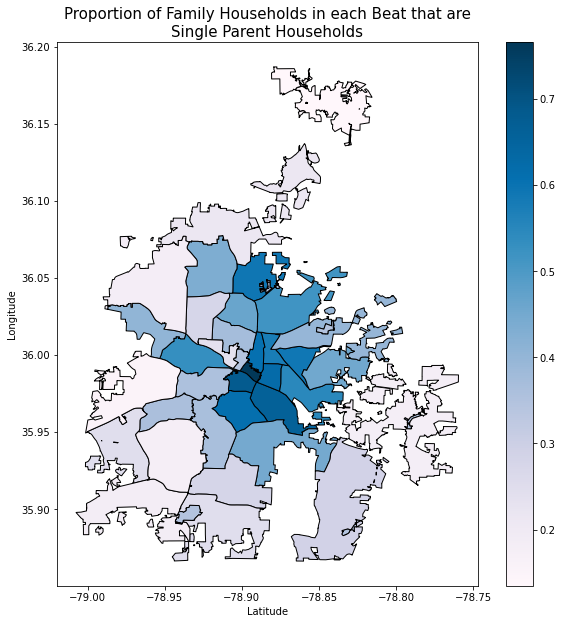

In [180]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Family Households in each Beat that are\nSingle Parent Households", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [181]:
#correlation with pvalue
stats.pearsonr(beats_callcount_pop_age_householdtype['callcountperperson'], beats_callcount_pop_age_householdtype['propsingleparent'])


(0.5920473171562772, 0.0001134275114713584)

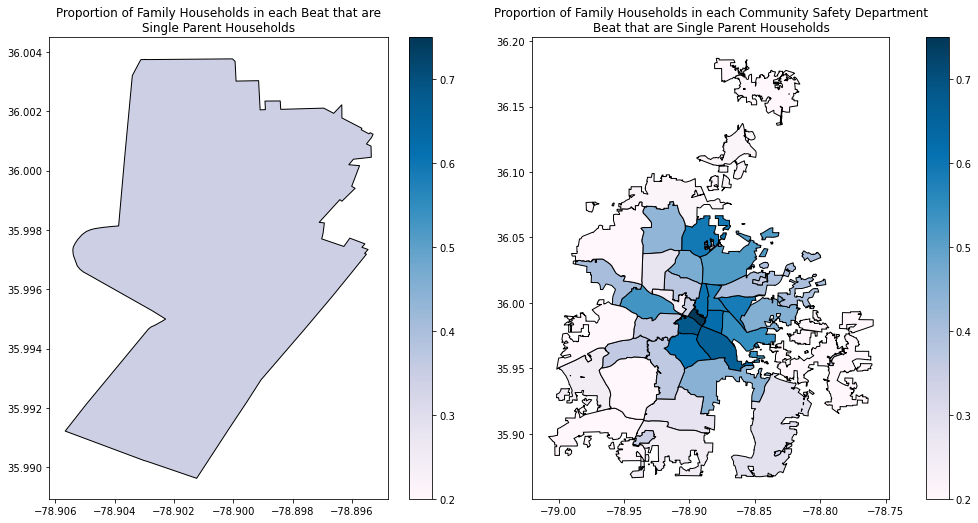

In [182]:
fig = plt.figure(constrained_layout=True, figsize=(20, 20))

gridspan = fig.add_gridspec(1, 1)

gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

ax2 = fig.add_subplot(gs[0, 1])

ax1.title.set_text('Proportion of Family Households in each Beat that are\nSingle Parent Households')

ax2.title.set_text('Proportion of Family Households in each Community Safety Department\nBeat that are Single Parent Households')

vmin, vmax = 0.2, 0.75

#Plot subplots
mappingdatasetforpolicebeats_w_householdtypenine.plot(column='propsingleparent',
                                legend=True,
                                vmin = vmin, vmax = vmax, 
                                cmap="PuBu", ax=ax1, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                vmin = vmin, vmax = vmax, 
                                cmap="PuBu", ax=ax2, aspect=1, edgecolor='black');

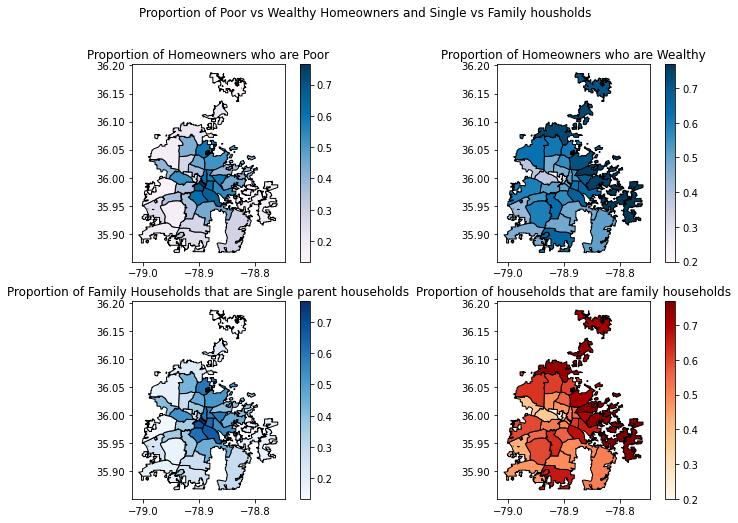

In [183]:
#Plot subplots of racial data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]
ax11.title.set_text('Proportion of Homeowners who are Poor')
ax12.title.set_text('Proportion of Homeowners who are Wealthy')
ax21.title.set_text('Proportion of Family Households that are Single parent households')
ax22.title.set_text('Proportion of households that are family households')

# Set figure title
fig.suptitle("Proportion of Poor vs Wealthy Homeowners and Single vs Family housholds")

#Plot subplots
mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="PuBu", ax=ax11, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propfamilyhouseholds',
                                legend=True,
                                cmap="PuBu", ax=ax12, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propsingleparent',
                                legend=True,
                                cmap="Blues", ax=ax21, aspect=1, edgecolor='black');

mappingdatasetforpolicebeats_w_householdtype.plot(column='propfamilyhouseholds',
                                legend=True,
                                cmap="OrRd", ax=ax22, aspect=1, edgecolor='black');

plt.show()

start looking at race data

In [184]:
racedata = pd.read_csv('/Users/erikrobertsson/Downloads/Race data files/DECENNIALPL2020.P1_data_with_overlays_2022-06-02T110204.csv', skiprows =1)
racedata['GEOID20'] = racedata['id'].str[-15:]
racedata.drop('id', axis=1, inplace=True)
racedata.columns = racedata.columns.str.replace(' !!T', 'T')
racedata.columns = racedata.columns.str.replace('[#,@,&,!]', '')
racedata.columns = racedata.columns.str.replace('[:]', ' ')
racedata.columns = racedata.columns.str.replace('of one race', 'of')
racedata.rename(columns = {'Total Population of two or more races ':'Total Mixed Races'}, inplace = True)
racedata.rename(columns = {'Total ':'Total Population'}, inplace = True)
racedata.drop('Total Population of ', axis=1, inplace=True)
racedata.drop(racedata.iloc[:, 9:71], inplace = True, axis = 1)
racedata

Geographic Area Name  Total Population  \
0     Block 1000, Block Group 1, Census Tract 1.01, ...               108   
1     Block 1001, Block Group 1, Census Tract 1.01, ...                35   
2     Block 1002, Block Group 1, Census Tract 1.01, ...                38   
3     Block 1003, Block Group 1, Census Tract 1.01, ...                43   
4     Block 1004, Block Group 1, Census Tract 1.01, ...                31   
...                                                 ...               ...   
4396  Block 1068, Block Group 1, Census Tract 9801, ...                 0   
4397  Block 1069, Block Group 1, Census Tract 9801, ...                 0   
4398  Block 1070, Block Group 1, Census Tract 9801, ...                 0   
4399  Block 1071, Block Group 1, Census Tract 9801, ...                 0   
4400  Block 1072, Block Group 1, Census Tract 9801, ...                 0   

      Total Population of White alone  \
0                                  18   
1                                  13   
2                                  17   
3                                  21   
4                                   5   
...                               ...   
4396                                0   
4397                                0   
4398                                0   
4399                                0   
4400                                0   

      Total Population of Black or African American alone  \
0                                                    61     
1                                                     5     
2                                                     9     
3                                                    19     
4                                                    18     
...                                                 ...     
4396                                                  0     
4397                                                  0     
4398                                                  0     
4399                                                  0     
4400                                                  0     

      Total Population of American Indian and Alaska Native alone  \
0                                                     3             
1                                                     0             
2                                                     0             
3                                                     0             
4                                                     0             
...                                                 ...             
4396                                                  0             
4397                                                  0             
4398                                                  0             
4399                                                  0             
4400                                                  0             

      Total Population of Asian alone  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   1   
...                               ...   
4396                                0   
4397                                0   
4398                                0   
4399                                0   
4400                                0   

      Total Population of Native Hawaiian and Other Pacific Islander alone  \
0                                                     0                      
1                                                     0                      
2                                                     0                      
3                                                     0                      
4                                                     0                      
...                                                 ...                      
4396            

In [185]:
racedatadurhambyblocks = pd.merge(cblockDurhamBeats, racedata, left_on ='GEOID20', right_on='GEOID20')
racedatadurhambyblocks.drop(['MTFCC20', 'UR20', 'BLOCKCE20', 'UACE20', 'UATYPE20', 'COUNTYFP20', 'FUNCSTAT20', 'ALAND20', 'AWATER20', 'TRACTCE20', 'STATEFP20'], axis=1, inplace=True)
racedatadurhambyblocks

GEOID20      NAME20   INTPTLAT20    INTPTLON20  \
0     370630021004022  Block 4022  +36.1529771  -078.8218382   
1     370630020362000  Block 2000  +35.9051346  -078.9104302   
2     370630021002004  Block 2004  +36.1825702  -078.8798060   
3     370630020201013  Block 1013  +35.8938510  -078.9448088   
4     370630017122001  Block 2001  +36.0548720  -078.9454010   
...               ...         ...          ...           ...   
3331  370630022002048  Block 2048  +35.9949422  -078.8981501   
3332  370630022001012  Block 1012  +36.0007075  -078.9093748   
3333  370630007003016  Block 3016  +35.9725240  -078.9247163   
3334  370630020262014  Block 2014  +35.9492235  -078.8954035   
3335  370630013011001  Block 1001  +35.9810471  -078.8944621   

                                               geometry  Beat  \
0     POLYGON ((-78.83005 36.15073, -78.83001 36.150...   299   
1     POLYGON ((-78.91719 35.90556, -78.91702 35.905...   421   
2     POLYGON ((-78.89032 36.18674, -78.89020 36.187...   299   
3     POLYGON ((-78.94746 35.89382, -78.94728 35.893...   324   
4     POLYGON ((-78.95554 36.05137, -78.95553 36.051...   221   
...                                                 ...   ...   
3331  POLYGON ((-78.89883 35.99520, -78.89876 35.995...   512   
3332  POLYGON ((-78.90950 36.00138, -78.90934 36.001...   511   
3333  POLYGON ((-78.92578 35.97207, -78.92571 35.972...   415   
3334  POLYGON ((-78.89768 35.94758, -78.89762 35.947...   414   
3335  POLYGON ((-78.89541 35.98186, -78.89539 35.981...   411   

                                   Geographic Area Name  Total Population  \
0     Block 4022, Block Group 4, Census Tract 21, Du...                88   
1     Block 2000, Block Group 2, Census Tract 20.36,...              1240   
2     Block 2004, Block Group 2, Census Tract 21, Du...                52   
3     Block 1013, Block Group 1, Census Tract 20.20,...               126   
4     Block 2001, Block Group 2, Census Tract 17.12,...               210   
...                                                 ...               ...   
3331  Block 2048, Block Group 2, Census Tract 22, Du...                 0   
3332  Block 1012, Block Group 1, Census Tract 22, Du...                 0   
3333  Block 3016, Block Group 3, Census Tract 7, Dur...                25   
3334  Block 2014, Block Group 2, Census Tract 20.26,...                62   
3335  Block 1001, Block Group 1, Census Tract 13.01,...                55   

      Total Population of White alone  \
0                                  82   
1                                 461   
2                                  48   
3                                  86   
4                                 152   
...                               ...   
3331                                0   
3332                                0   
3333                               18   
3334                               10   
3335                                8   

      Total Population of Black or African American alone  \
0                                                     5     
1                                                   580     
2                                                     4     
3                                                    14     
4                                                    14     
...                                                 ...     
3331                                                  0     
3332                                                  0     
3333                                                  6     
3334                                                 44     
3335                                                 40     

      Total Population of American Indian and Alaska Native alone  \
0                                                     0             
1                                                     3             
2                                                     0             
3                                    

In [186]:
racesumbybeat = racedatadurhambyblocks.groupby('Beat', as_index=False).sum()
racesumbybeat

Beat  Total Population  Total Population of White alone  \
0    111              3949                             1242   
1    112              3083                              454   
2    113              4094                              891   
3    114              5631                              741   
4    121              8025                             1485   
5    122              3209                              315   
6    123              9036                             1113   
7    124             14913                             7361   
8    211              6544                             4211   
9    212              7901                             4863   
10   213              4962                             1916   
11   214              6628                              982   
12   221             10284                             7406   
13   222             10888                             3357   
14   223              8338                             1238   
15   224             11682                             5549   
16   299               540                              468   
17   311              6954                             3571   
18   312              7865                             2056   
19   313             12372                             5005   
20   314              6616                             2618   
21   321              9605                             6098   
22   322             15927                            10592   
23   323              9264                             4709   
24   324             10982                             7140   
25   411              3261                              546   
26   412              7737                              378   
27   413              4808                              363   
28   414             10761                             3046   
29   415              9436                             2609   
30   421             13874                             5987   
31   422             11497                             5481   
32   423             15092                             6642   
33   511              5505                             2826   
34   512              1646                             1076   
35   513              1677                              405   
36   999               194                               86   

    Total Population of Black or African American alone  \
0                                                1487     
1                                                1276     
2                                                2046     
3                                                2981     
4                                                4619     
5                                                1398     
6                                                5136     
7                                                5032     
8                                                 813     
9                                                1303     
10                                               1354     
11                                               3844     
12                                               1234     
13                                               4278     
14                                               5322     
15                                               4021     
16                                                 37     
17                                               1915     
18                                               4063     
19                                               3001     
20                                               1953     
21                                                973     
22                                               2893     
23                                               2324     
24                                               1683     
25                                               2094     
26              

In [187]:
racesumbybeat['Total Population'].sum()

284780

In [188]:
beats_callcount_pop_age_householdtype_race = pd.merge(beats_callcount_pop_age_householdtype, racesumbybeat, left_on ='LAWBEAT', right_on='Beat')
beats_callcount_pop_age_householdtype_race['propwhite']= beats_callcount_pop_age_householdtype_race['Total Population of White alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propblack']= beats_callcount_pop_age_householdtype_race['Total Population of Black or African American alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propasian']= beats_callcount_pop_age_householdtype_race['Total Population of Asian alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propnative']= beats_callcount_pop_age_householdtype_race['Total Population of American Indian and Alaska Native alone'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race['propmixed']= beats_callcount_pop_age_householdtype_race['Total Mixed Races'] / beats_callcount_pop_age_householdtype_race['Total Population']
beats_callcount_pop_age_householdtype_race

LAWBEAT  OBJECTID      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left  \
0       111      50.0   28608.800781  2.010252e+07   28608.799743      111.0   
1       112      51.0   26265.849609  2.079934e+07   26265.852604      112.0   
2       113      62.0   20667.539062  2.159195e+07   20667.538873      113.0   
3       114      65.0   53321.980469  6.103382e+07   53321.974873      114.0   
4       121      38.0   14495.120117  7.008533e+06   14495.120026      121.0   
5       122      54.0   36686.679688  3.436298e+07   36686.681354      122.0   
6       123      55.0   74375.859375  7.495698e+07   74375.856455      123.0   
7       124      63.0   10708.070312  3.022588e+06   10708.070450      124.0   
8       211      36.0   36748.878906  6.487864e+07   36748.875052      211.0   
9       212      43.0   37127.789062  4.301152e+07   37127.786492      212.0   
10      213      37.0   28560.539062  4.691512e+07   28560.540431      213.0   
11      214      23.0    1715.291016  1.329736e+05    1715.290848      214.0   
12      221      17.0   87384.078125  2.027947e+08   87384.076005      221.0   
13      222      16.0   50498.308594  1.066247e+08   50498.309761      222.0   
14      223      21.0   16095.400391  6.891411e+06   16095.395041      223.0   
15      224      12.0   94210.453125  7.014559e+07   94210.453140      224.0   
16      299       1.0   29657.869141  2.075708e+07   29657.868615      299.0   
17      311      66.0   48409.859375  6.081916e+07   48409.861058      311.0   
18      312      52.0   42676.800781  6.884782e+07   42676.796572      312.0   
19      313      39.0   57403.839844  6.812116e+07   57403.841356      313.0   
20      314      78.0   38782.281250  5.416068e+07   38782.281943      314.0   
21      321      58.0  122575.601562  1.593645e+08  122575.571649      321.0   
22      322      87.0   60429.371094  1.639988e+08   60429.372056      322.0   
23      323      80.0   74252.812500  1.066631e+08   74252.813082      323.0   
24      324     106.0  128371.601562  1.523746e+08  128371.584023      324.0   
25      411      67.0   24141.640625  2.140812e+07   24141.641318      411.0   
26      412      75.0   33732.519531  5.757125e+07   33732.518542      412.0   
27      413      71.0   45203.929688  6.563018e+07   45203.932226      413.0   
28      414      88.0   98360.617188  1.342096e+08   98360.616926      414.0   
29      415      79.0   60313.781250  8.843634e+07   60313.778960      415.0   
30      421      99.0   58692.320312  1.180636e+08   58692.323104      421.0   
31      422     108.0  119968.398438  1.364002e+08  119968.366828      422.0   
32      423      95.0  151917.093750  2.561465e+08  151917.121852      423.0   
33      511      53.0   32615.019531  2.129644e+07   32615.017763      511.0   
34      512      57.0   16338.889648  9.305014e+06   16338.888321      512.0   
35      513      61.0   20647.179688  9.114313e+06   20647.175971      513.0   
36      999       4.0    1308.963013  6.932677e+04    1308.962953      999.0   

      id    index_right    Event Numb             X              Y  Cancelled  \
0    0.0  144556.454178  2.124067e+07  2.032488e+06  817873.029067        0.0   
1    1.0  141814.763496  2.123627e+07  2.035512e+06  818871.362039        0.0   
2    2.0  139624.402959  2.123224e+07  2.035223e+06  814263.195844        0.0   
3    3.0  140596.262032  2.123422e+07  2.040281e+06  812064.585383        0.0   
4    4.0  143320.079359  2.123890e+07  2.045828e+06  824005.007615        0.0   
5    5.0  143562.447557  2.123929e+07  2.039433e+06  817595.542997        0.0   
6    6.0  144876.994257  2.124150e+07  2.046093e+06  815364.300536        0.0   
7    7.0  144959.805145  2.124171e+07  2.058114e+06  802758.864806        0.0   
8    8.0  138694.192452  2.123069e+07  2.022369e+06  828201.705835        0.0   
9    9.0  141527.279760  2.123573e+07  2.027481e+06  823625.628039        0.0   
10  10.0  152831.835538  2.125491e+07  2.029096e+06  829503.438758      

end of race

In [189]:
beats_callcount_pop_income_householdtype_race_age = pd.merge(beats_callcount_pop_age_householdtype_race, incomesumbybeat, left_on ='LAWBEAT', right_on='Beat')
#beats_callcount_pop_income_householdtype_race_age_correl = beats_callcount_pop_income_householdtype_race_age.dropna()
#beats_callcount_pop_income_householdtype_race_age.sort_values(by='popdensity', inplace=True, ascending=False)
beats_callcount_pop_income_householdtype_race_age['callcountperarea']= beats_callcount_pop_income_householdtype_race_age['calls_count'] / beats_callcount_pop_income_householdtype_race_age['area']
beats_callcount_pop_income_householdtype_race_age['propmiddleincome']= beats_callcount_pop_income_householdtype_race_age['prop_50to75'] + beats_callcount_pop_income_householdtype_race_age['prop_75to100']
beats_callcount_pop_income_householdtype_race_age['propadultsandboomers']= beats_callcount_pop_income_householdtype_race_age['propadults'] + beats_callcount_pop_income_householdtype_race_age['propboomers']
beats_callcount_pop_income_householdtype_race_age['propyouthandchildren']= beats_callcount_pop_income_householdtype_race_age['propyouth'] + beats_callcount_pop_income_householdtype_race_age['propchildren']
beats_callcount_pop_income_householdtype_race_age['propboomersandseniors']= beats_callcount_pop_income_householdtype_race_age['propseniors'] + beats_callcount_pop_income_householdtype_race_age['propboomers']
beats_callcount_pop_income_householdtype_race_age.drop(['OBJECTID', 'index_right', 'Cancelled', 'ALAND20', 'AWATER20', 'index_right', 'Event Numb'], axis=1, inplace=True)
beats_callcount_pop_income_householdtype_race_age

LAWBEAT      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left    id  \
0       111   28608.800781  2.010252e+07   28608.799743      111.0   0.0   
1       112   26265.849609  2.079934e+07   26265.852604      112.0   1.0   
2       113   20667.539062  2.159195e+07   20667.538873      113.0   2.0   
3       114   53321.980469  6.103382e+07   53321.974873      114.0   3.0   
4       121   14495.120117  7.008533e+06   14495.120026      121.0   4.0   
5       122   36686.679688  3.436298e+07   36686.681354      122.0   5.0   
6       123   74375.859375  7.495698e+07   74375.856455      123.0   6.0   
7       124   10708.070312  3.022588e+06   10708.070450      124.0   7.0   
8       211   36748.878906  6.487864e+07   36748.875052      211.0   8.0   
9       212   37127.789062  4.301152e+07   37127.786492      212.0   9.0   
10      213   28560.539062  4.691512e+07   28560.540431      213.0  10.0   
11      214    1715.291016  1.329736e+05    1715.290848      214.0  11.0   
12      221   87384.078125  2.027947e+08   87384.076005      221.0  12.0   
13      222   50498.308594  1.066247e+08   50498.309761      222.0  13.0   
14      223   16095.400391  6.891411e+06   16095.395041      223.0  14.0   
15      224   94210.453125  7.014559e+07   94210.453140      224.0  15.0   
16      311   48409.859375  6.081916e+07   48409.861058      311.0  17.0   
17      312   42676.800781  6.884782e+07   42676.796572      312.0  18.0   
18      313   57403.839844  6.812116e+07   57403.841356      313.0  19.0   
19      314   38782.281250  5.416068e+07   38782.281943      314.0  20.0   
20      321  122575.601562  1.593645e+08  122575.571649      321.0  21.0   
21      322   60429.371094  1.639988e+08   60429.372056      322.0  22.0   
22      323   74252.812500  1.066631e+08   74252.813082      323.0  23.0   
23      324  128371.601562  1.523746e+08  128371.584023      324.0  24.0   
24      411   24141.640625  2.140812e+07   24141.641318      411.0  25.0   
25      412   33732.519531  5.757125e+07   33732.518542      412.0  26.0   
26      413   45203.929688  6.563018e+07   45203.932226      413.0  27.0   
27      414   98360.617188  1.342096e+08   98360.616926      414.0  28.0   
28      415   60313.781250  8.843634e+07   60313.778960      415.0  29.0   
29      421   58692.320312  1.180636e+08   58692.323104      421.0  30.0   
30      422  119968.398438  1.364002e+08  119968.366828      422.0  31.0   
31      423  151917.093750  2.561465e+08  151917.121852      423.0  32.0   
32      511   32615.019531  2.129644e+07   32615.017763      511.0  33.0   
33      512   16338.889648  9.305014e+06   16338.888321      512.0  34.0   
34      513   20647.179688  9.114313e+06   20647.175971      513.0  35.0   

               X              Y  calls_count      area  Beat_x  total  \
0   2.032488e+06  817873.029067       2477.0  0.000187     111   3949   
1   2.035512e+06  818871.362039       2334.0  0.000193     112   3083   
2   2.035223e+06  814263.195844       2839.0  0.000200     113   4094   
3   2.040281e+06  812064.585383       2805.0  0.000616     114   5631   
4   2.045828e+06  824005.007615       2495.0  0.001061     121   8025   
5   2.039433e+06  817595.542997       3070.0  0.000319     122   3209   
6   2.046093e+06  815364.300536       2612.0  0.000711     123   9036   
7   2.058114e+06  802758.864806       1827.0  0.002269     124  14913   
8   2.022369e+06  828201.705835       3736.0  0.000603     211   6544   
9   2.027481e+06  823625.628039       3167.0  0.000400     212   7901   
10  2.029096e+06  829503.438758       3478.0  0.000436     213   4962   
11  2.035165e+06  828531.947593       3511.0  0.001084     214   6628   
12  2.014415e+06  830652.278659       3847.0  0.001929     221  10284   
13  2.023739e+06  837930.192982       3021.0  0.000991     222  10888   
14  2.031555e+06  836327.035640       4826.0  0.000654     223   8338   
15  2.027810e+06  848119.941511       2462.0  0.002107     224  11682   
16  2.022744e+06  812695.0

start of poverty level

In [190]:
povertydata = pd.read_csv('/Users/erikrobertsson/Documents/dataplus/povertyleveldata2/ACSDT5Y2020.B17017_data_with_overlays_2022-07-01T121722.csv', skiprows =1)
povertydata['GEOID'] = povertydata['id'].str[-12:]
povertydata.drop('id', axis=1, inplace=True)
povertydata = povertydata.drop(povertydata.filter(regex='Margin').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months below poverty level:!!Family households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months below poverty level:!!Nonfamily households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!Family households:!!').columns, axis=1)
povertydata = povertydata.drop(povertydata.filter(regex='Estimate!!Total:!!Income in the past 12 months at or above poverty level:!!Nonfamily households:!!').columns, axis=1)
povertydata.rename(columns=lambda s: s.replace("Estimate!!Total:!!Income in the past 12 months", "Total People"), inplace=True)
povertydata.rename(columns=lambda s: s.replace(":!!", " "), inplace=True)
povertydata.rename(columns=lambda s: s.replace(":", ""), inplace=True)
povertydata.rename(columns = {'Estimate!!Total':'Total People'}, inplace = True)
povertydata = povertydata[['GEOID', 'Geographic Area Name', 'Total People', 'Total People below poverty level', 'Total People below poverty level Family households', 'Total People below poverty level Nonfamily households', 'Total People at or above poverty level','Total People at or above poverty level Family households', 'Total People at or above poverty level Nonfamily households',]]
povertydata.head(2)

GEOID                               Geographic Area Name  \
0  370630001011  Block Group 1, Census Tract 1.01, Durham Count...   
1  370630001012  Block Group 2, Census Tract 1.01, Durham Count...   

   Total People  Total People below poverty level  \
0           563                                57   
1           859                               105   

   Total People below poverty level Family households  \
0                                                 36    
1                                                 67    

   Total People below poverty level Nonfamily households  \
0                                                 21       
1                                                 38       

   Total People at or above poverty level  \
0                                     506   
1                                     754   

   Total People at or above poverty level Family households  \
0                                                214          
1                                                552          

   Total People at or above poverty level Nonfamily households  
0                                                292            
1                                                202

In [191]:
povertydataindurhambyblocks = pd.merge(cblockDurhamBeatsbg, povertydata, left_on ='GEOID', right_on='GEOID')
povertydataindurhambyblocks.drop(['MTFCC', 'COUNTYFP','NAMELSAD', 'FUNCSTAT', 'ALAND', 'AWATER', 'TRACTCE', 'STATEFP', 'BLKGRPCE'], axis=1, inplace=True)
povertydataindurhambyblocks.head(2)

GEOID     INTPTLAT      INTPTLON  \
0  370630020191  +35.9028449  -078.9763172   
1  370630020201  +35.8836714  -078.9598590   

                                            geometry  Beat  \
0  POLYGON ((-78.98415 35.91174, -78.98394 35.911...   324   
1  POLYGON ((-78.97849 35.86682, -78.97764 35.867...   324   

                                Geographic Area Name  Total People  \
0  Block Group 1, Census Tract 20.19, Durham Coun...           943   
1  Block Group 1, Census Tract 20.20, Durham Coun...           862   

   Total People below poverty level  \
0                                65   
1                                 0   

   Total People below poverty level Family households  \
0                                                  0    
1                                                  0    

   Total People below poverty level Nonfamily households  \
0                                                 65       
1                                                  0       

   Total People at or above poverty level  \
0                                     878   
1                                     862   

   Total People at or above poverty level Family households  \
0                                                267          
1                                                671          

   Total People at or above poverty level Nonfamily households  
0                                                611            
1                                                191

In [192]:
povertysumbybeat = povertydataindurhambyblocks.groupby('Beat', as_index=False).sum()
povertysumbybeat.rename(columns = {'Beat':'LAWBEAT'}, inplace = True)
povertysumbybeat['propbelowpov']= povertysumbybeat['Total People below poverty level'] / povertysumbybeat['Total People']
povertysumbybeat['propabovepov']= povertysumbybeat['Total People at or above poverty level'] / povertysumbybeat['Total People']
povertysumbybeat = povertysumbybeat[['Total People', 'Total People below poverty level', 'Total People below poverty level Family households', 'Total People below poverty level Nonfamily households', 'Total People at or above poverty level','Total People at or above poverty level Family households', 'Total People at or above poverty level Nonfamily households', 'LAWBEAT', 'propbelowpov', 'propabovepov']]
povertysumbybeat.sort_values(by='propbelowpov', inplace=True, ascending=False)
povertysumbybeat

Total People  Total People below poverty level  \
5            427                               181   
1           1152                               468   
14           385                               135   
25          1983                               559   
2           1339                               366   
17          1076                               292   
0           1275                               346   
24          1947                               528   
4           1204                               312   
31           898                               231   
32           731                               180   
23          1052                               246   
6           2242                               499   
19          1219                               223   
3            891                               149   
12           965                               158   
27          3006                               468   
10          1059                               159   
16          2479                               369   
26          1803                               248   
9           3393                               460   
13          3976                               455   
11          2555                               279   
30          1125                               118   
8           1871                               195   
29          2615                               232   
33           244                                21   
22          3292                               208   
28          2585                               152   
18          1656                                97   
15          2776                               150   
20          2274                                82   
7           3130                               101   
21          4046                               124   

    Total People below poverty level Family households  \
5                                                  33    
1                                                 321    
14                                                 16    
25                                                319    
2                                                 150    
17                                                 51    
0                                                 127    
24                                                321    
4                                                 265    
31                                                  0    
32                                                  0    
23                                                 58    
6                                                 428    
19                                                115    
3                                                 123    
12                                                 21    
27                                                314    
10                                                 88    
16                                                256    
26                                                144    
9                                                 211    
13                                                266    
11                                                201    
30                                                  0    
8                                                  37    
29                                                177    
33                                                 13    
22                                                 57    
28                                                 53    
18                                                 18    
15                                                 85    
20                                                 16    
7                                                  27    
21                                                 28    

    Total People below poverty level Nonfamily households  \
5                    

In [193]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
povertysumbybeatcommsafe = povertysumbybeat.loc[povertysumbybeat['LAWBEAT'].isin(commsafe_list)].copy()
povertysumbybeatcommsafe

Total People  Total People below poverty level  \
1           1152                               468   
14           385                               135   
0           1275                               346   
31           898                               231   
32           731                               180   
23          1052                               246   
11          2555                               279   
33           244                                21   

    Total People below poverty level Family households  \
1                                                 321    
14                                                 16    
0                                                 127    
31                                                  0    
32                                                  0    
23                                                 58    
11                                                201    
33                                                 13    

    Total People below poverty level Nonfamily households  \
1                                                 147       
14                                                119       
0                                                 219       
31                                                231       
32                                                180       
23                                                188       
11                                                 78       
33                                                  8       

    Total People at or above poverty level  \
1                                      684   
14                                     250   
0                                      929   
31                                     667   
32                                     551   
23                                     806   
11                                    2276   
33                                     223   

    Total People at or above poverty level Family households  \
1                                                 358          
14                                                222          
0                                                 533          
31                                                107          
32                                                 77          
23                                                489          
11                                               1307          
33                                                 74          

    Total People at or above poverty level Nonfamily households  LAWBEAT  \
1                                                 326                112   
14                                                 28                223   
0                                                 396                111   
31                                                560                511   
32                                                474                512   
23                                                317                411   
11                                                969                214   
33                                                149                513   

    propbelowpov  propabovepov  
1       0.406250      0.593750  
14      0.350649      0.649351  
0       0.271373      0.728627  
31      0.257238      0.742762  
32      0.246238      0.753762  
23      0.233840      0.766160  
11      0.109198      0.890802  
33      0.086066      0.913934

In [194]:
meanpropbelowpov = povertysumbybeat[["propbelowpov"]].mean()
meanpropbelowpov

propbelowpov    0.175052
dtype: float64

In [195]:
meanpropbelowpovcommsafe = povertysumbybeatcommsafe[["propbelowpov"]].mean()
meanpropbelowpovcommsafe

propbelowpov    0.245106
dtype: float64

In [197]:
povertydata['Total People'].sum()

130128

In [198]:
mappingdatasetpoverty = pd.merge(policebeats, povertysumbybeat, on ='LAWBEAT')

In [199]:
commsafe_list = [511, 512, 513, 411, 111, 112, 214, 223]
mappingdatasetpovertycommsafe = mappingdatasetpoverty.loc[mappingdatasetpoverty['LAWBEAT'].isin(commsafe_list)].copy()

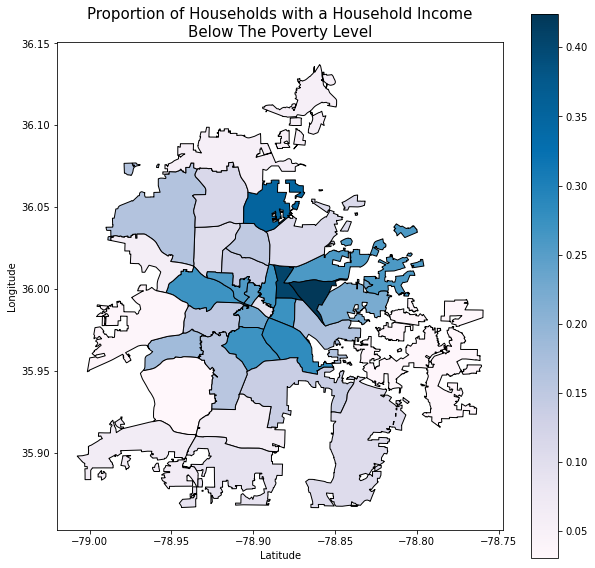

In [200]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetpoverty.plot(column='propbelowpov',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households with a Household Income\nBelow The Poverty Level", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

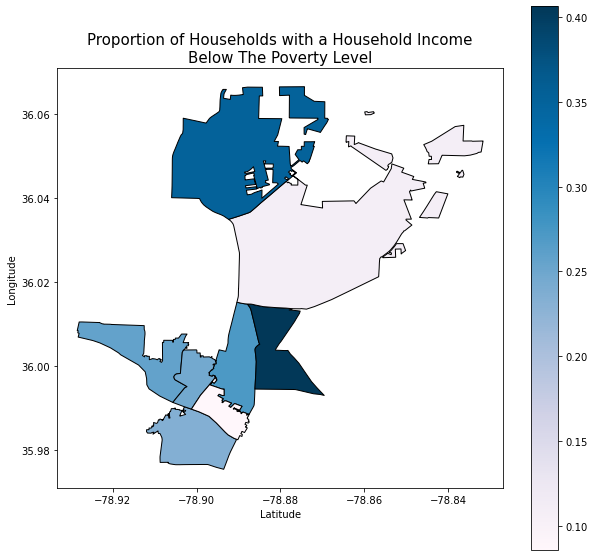

In [218]:
#Plot chloropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
mappingdatasetpovertycommsafe.plot(column='propbelowpov',
                                legend=True,
                                cmap="PuBu", ax=ax, aspect=1, edgecolor = 'black');

# ax.set(title='Number of Calls by Police Beat')
plt.title("Proportion of Households with a Household Income\nBelow The Poverty Level", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [221]:
beats_callcount_pop_income_householdtype_race_age_poverty = pd.merge(beats_callcount_pop_income_householdtype_race_age, povertysumbybeat, on ='LAWBEAT')
stats.pearsonr(beats_callcount_pop_income_householdtype_race_age_poverty['propbelowpov'], beats_callcount_pop_income_householdtype_race_age_poverty['callcountperperson'])


(0.38661043777824394, 0.023907139535015224)

In [223]:
pd.set_option('display.max_rows', None)
beats_callcount_pop_income_householdtype_race_age.corr()

LAWBEAT  PERIMETER  \
LAWBEAT                                             1.000000   0.254658   
PERIMETER                                           0.254658   1.000000   
ShapeSTAre                                          0.261528   0.888869   
ShapeSTLen                                          0.254658   1.000000   
Beat_left                                           1.000000   0.254658   
id                                                  0.982729   0.359968   
X                                                  -0.321392  -0.286127   
Y                                                  -0.435186  -0.501202   
calls_count                                         0.224403   0.395276   
area                                               -0.032325   0.634853   
Beat_x                                              1.000000   0.254658   
total                                               0.050962   0.578020   
total_hispanic_or_latino                           -0.526563   0.079818   
total_not_hispanic_or_latino                        0.132636   0.586454   
popdensity                                          0.197937  -0.469004   
callcountperperson                                  0.242499  -0.432623   
prophisp                                           -0.632893  -0.349522   
Beat_y                                              1.000000   0.254658   
14 years and under                                 -0.214665   0.456371   
15 to 24 years                                      0.217504   0.111641   
25 to 39 years                                      0.096943   0.559570   
40 to 64 years                                     -0.083292   0.516389   
65 years and over                                   0.013947   0.468675   
popcount2010                                        0.020397   0.559019   
propfemale                                         -0.109819   0.234967   
propmale                                            0.109819  -0.234967   
propadults                                          0.142798   0.245481   
propboomers                                        -0.271317   0.078978   
propyouth                                           0.338707  -0.209367   
propchildren                                       -0.568999  -0.095253   
propseniors                                         0.042647   0.207179   
Beat_x                                              1.000000   0.254658   
Total Households                                    0.076740   0.611929   
Total Family households                            -0.068474   0.561336   
Total Family households Husband-wife family        -0.005991   0.602808   
Total Single Parent Households                     -0.221893   0.149537   
Total Single Father Households                     -0.275406   0.268621   
Total Single Mother Households                     -0.195772   0.113082   
Total Nonfamily households                          0.228392   0.551621   
Total Nonfamily households Householder living a...  0.218482   0.576124   
Total Nonfamily households Householder not livi...  0.224926   0.415971   
propsingleparent                                   -0.101939  -0.542769   
propsinglemom                                      -0.051514  -0.514459   
propsinglefather                                   -0.244892  -0.436091   
propfamilyhouseholds                               -0.562746  -0.003711   
proptwoparent                                       0.101939   0.542769   
householdsdensity                                  -0.054366  -0.281125   
Beat_y                                              1.000000   0.254658   
Total Population                                    0.050962   0.578020   
Total Population of White alone                     0.104239   0.583757   
Total Population of Black or African American a...  0.016364   0.106446   
Total Population of American Indian and Alaska ... -0.645534  -0.019103   
Total Population of Asian alone                     0.272260   0.626974   
Tot

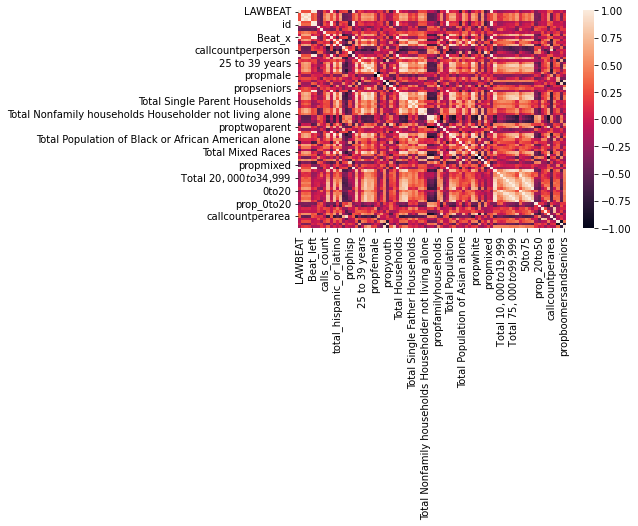

In [203]:
sns.heatmap(beats_callcount_pop_income_householdtype_race_age.corr());

In [204]:
stats.pearsonr(beats_callcount_pop_income_householdtype_race_age['propsinglemom'], beats_callcount_pop_income_householdtype_race_age['prop_100plus'])


(-0.8720342491259102, 9.020998268494107e-12)

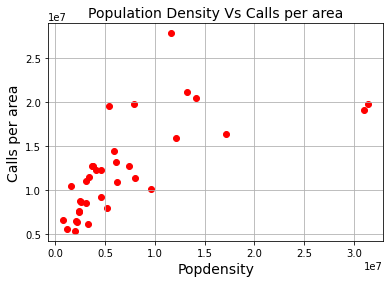

In [205]:
plt.scatter(beats_callcount_pop_income_householdtype_race_age['callcountperarea'], beats_callcount_pop_income_householdtype_race_age['popdensity'], color='red')
plt.title('Population Density Vs Calls per area', fontsize=14)
plt.xlabel('Popdensity', fontsize=14)
plt.ylabel('Calls per area', fontsize=14)
plt.grid(True)
plt.show()

In [206]:
beats_callcount_pop_income_householdtype_race_age

LAWBEAT      PERIMETER    ShapeSTAre     ShapeSTLen  Beat_left    id  \
0       111   28608.800781  2.010252e+07   28608.799743      111.0   0.0   
1       112   26265.849609  2.079934e+07   26265.852604      112.0   1.0   
2       113   20667.539062  2.159195e+07   20667.538873      113.0   2.0   
3       114   53321.980469  6.103382e+07   53321.974873      114.0   3.0   
4       121   14495.120117  7.008533e+06   14495.120026      121.0   4.0   
5       122   36686.679688  3.436298e+07   36686.681354      122.0   5.0   
6       123   74375.859375  7.495698e+07   74375.856455      123.0   6.0   
7       124   10708.070312  3.022588e+06   10708.070450      124.0   7.0   
8       211   36748.878906  6.487864e+07   36748.875052      211.0   8.0   
9       212   37127.789062  4.301152e+07   37127.786492      212.0   9.0   
10      213   28560.539062  4.691512e+07   28560.540431      213.0  10.0   
11      214    1715.291016  1.329736e+05    1715.290848      214.0  11.0   
12      221   87384.078125  2.027947e+08   87384.076005      221.0  12.0   
13      222   50498.308594  1.066247e+08   50498.309761      222.0  13.0   
14      223   16095.400391  6.891411e+06   16095.395041      223.0  14.0   
15      224   94210.453125  7.014559e+07   94210.453140      224.0  15.0   
16      311   48409.859375  6.081916e+07   48409.861058      311.0  17.0   
17      312   42676.800781  6.884782e+07   42676.796572      312.0  18.0   
18      313   57403.839844  6.812116e+07   57403.841356      313.0  19.0   
19      314   38782.281250  5.416068e+07   38782.281943      314.0  20.0   
20      321  122575.601562  1.593645e+08  122575.571649      321.0  21.0   
21      322   60429.371094  1.639988e+08   60429.372056      322.0  22.0   
22      323   74252.812500  1.066631e+08   74252.813082      323.0  23.0   
23      324  128371.601562  1.523746e+08  128371.584023      324.0  24.0   
24      411   24141.640625  2.140812e+07   24141.641318      411.0  25.0   
25      412   33732.519531  5.757125e+07   33732.518542      412.0  26.0   
26      413   45203.929688  6.563018e+07   45203.932226      413.0  27.0   
27      414   98360.617188  1.342096e+08   98360.616926      414.0  28.0   
28      415   60313.781250  8.843634e+07   60313.778960      415.0  29.0   
29      421   58692.320312  1.180636e+08   58692.323104      421.0  30.0   
30      422  119968.398438  1.364002e+08  119968.366828      422.0  31.0   
31      423  151917.093750  2.561465e+08  151917.121852      423.0  32.0   
32      511   32615.019531  2.129644e+07   32615.017763      511.0  33.0   
33      512   16338.889648  9.305014e+06   16338.888321      512.0  34.0   
34      513   20647.179688  9.114313e+06   20647.175971      513.0  35.0   

               X              Y  calls_count      area  Beat_x  total  \
0   2.032488e+06  817873.029067       2477.0  0.000187     111   3949   
1   2.035512e+06  818871.362039       2334.0  0.000193     112   3083   
2   2.035223e+06  814263.195844       2839.0  0.000200     113   4094   
3   2.040281e+06  812064.585383       2805.0  0.000616     114   5631   
4   2.045828e+06  824005.007615       2495.0  0.001061     121   8025   
5   2.039433e+06  817595.542997       3070.0  0.000319     122   3209   
6   2.046093e+06  815364.300536       2612.0  0.000711     123   9036   
7   2.058114e+06  802758.864806       1827.0  0.002269     124  14913   
8   2.022369e+06  828201.705835       3736.0  0.000603     211   6544   
9   2.027481e+06  823625.628039       3167.0  0.000400     212   7901   
10  2.029096e+06  829503.438758       3478.0  0.000436     213   4962   
11  2.035165e+06  828531.947593       3511.0  0.001084     214   6628   
12  2.014415e+06  830652.278659       3847.0  0.001929     221  10284   
13  2.023739e+06  837930.192982       3021.0  0.000991     222  10888   
14  2.031555e+06  836327.035640       4826.0  0.000654     223   8338   
15  2.027810e+06  848119.941511       2462.0  0.002107     224  11682   
16  2.022744e+06  812695.0

In [207]:
X = beats_callcount_pop_income_householdtype_race_age[['prop_20to50', 'prop_100plus', 'propsinglemom', 'propmale']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -1.9521721008225073
Coefficients: 
 [1.06556461 0.82284011 1.38628802 3.04179432]


In [208]:
New_Prop_20to50 = 0.2
New_Prop_100plus = 0.2
New_Prop_Singlemom = 0.4
New_Prop_Male = 0.5
print ('Predicted Call Count Per Person: \n', regr.predict([[New_Prop_20to50, New_Prop_100plus, New_Prop_Singlemom, New_Prop_Male]]))

Predicted Call Count Per Person: 
 [0.50092121]


In [209]:
import statsmodels.api as sm

In [210]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     callcountperperson   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     26.33
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           1.95e-09
Time:                        10:06:40   Log-Likelihood:                 14.440
No. Observations:                  35   AIC:                            -18.88
Df Residuals:                      30   BIC:                            -11.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.9522      0.314     -6.226

We expect that, on avagerage, a one unit increase in prop of poor homeowners will cause a 0.0251 increase in call count per person.

The y-intercept has no meaning because there cannot be negative calls per person.

In [211]:
model.rsquared_adj

0.7487112986629185

This adjusted R-squared value tells us that roughly 74.87% of the variability in call count per person can be explained by the proportion of low income homeowners and the proportion of the single parents households in a beat. Since this R-squared value is (not) closer to 1 than the r-squared value for the other model (), this new model is a better fit for the data.

In [217]:
df = pd.DataFrame(beats_callcount_pop_income_householdtype_race_age)

X = beats_callcount_pop_income_householdtype_race_age[['prop_20to50', 'prop_100plus', 'propsinglemom', 'propmale']] # here we have 2 variables for multiple regression. 
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

root= tk.Tk()

canvas1 = tk.Canvas(root, width = 500, height = 400)
canvas1.pack()

Intercept_result = ('Intercept: ', regr.intercept_)
label_Intercept = tk.Label(root, text=Intercept_result, justify = 'center')
canvas1.create_window(260, 250, window=label_Intercept)

Coefficients_result  = ('Coefficients: ', regr.coef_)
label_Coefficients = tk.Label(root, text=Coefficients_result, justify = 'center')
canvas1.create_window(260, 270, window=label_Coefficients)

label1 = tk.Label(root, text='Type Proportion of Household Incomes Between $20,000 and $50,000: ')
canvas1.create_window(-42, 100, window=label1)

entry1 = tk.Entry (root) # create 1st entry box
canvas1.create_window(270, 100, window=entry1)

label2 = tk.Label(root, text=' Type Proportion of Household Incomes Above $100,000: ')
canvas1.create_window(1, 130, window=label2)

entry2 = tk.Entry (root) # create 2nd entry box
canvas1.create_window(270, 130, window=entry2)

label3 = tk.Label(root, text=' Type Proportion of Family Households that are Single Mom: ')
canvas1.create_window(-5, 160, window=label3)

entry3 = tk.Entry (root) # create 3rd entry box
canvas1.create_window(270, 160, window=entry3)

label4 = tk.Label(root, text=' Type Proportion of Population that is Male: ')
canvas1.create_window(45, 190, window=label4)

entry4 = tk.Entry (root) # create 4th entry box
canvas1.create_window(270, 190, window=entry4)

def values(): 
    global New_Prop_20to50 #our 1st input variable
    New_Prop_20to50 = float(entry1.get()) 
    
    global New_Prop_100plus #our 2nd input variable
    New_Prop_100plus = float(entry2.get()) 
    
    global New_Prop_Singlemom #our 3rd input variable
    New_Prop_Singlemom = float(entry3.get()) 
    
    global New_Prop_Male #our 4th input variable
    New_Prop_Male = float(entry4.get()) 
    
    Prediction_result  = ('Predicted Call Count Per Person: ', regr.predict([[New_Prop_20to50 ,New_Prop_100plus ,New_Prop_Singlemom ,New_Prop_Male]]))
    label_Prediction = tk.Label(root, text= Prediction_result, bg='orange')
    canvas1.create_window(260, 320, window=label_Prediction)
    
button1 = tk.Button (root, text='Predict Call Count Per Person',command=values, bg='orange') # button to call the 'values' command above 
canvas1.create_window(270, 220, window=button1)

#plot 1st scatter 
figure3 = plt.Figure(figsize=(5,4), dpi=100)
ax3 = figure3.add_subplot(111)
ax3.scatter(df['prop_20to50'].astype(float),df['callcountperperson'].astype(float), color = 'purple')
scatter3 = FigureCanvasTkAgg(figure3, root) 
scatter3.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age['prop_20to50']
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
ax3.plot(X,Y,'o', color = 'purple')
ax3.plot(X,polyval(p1,X), 'r-', color = 'r')
ax3.legend(['callcountperperson'])
ax3.set_xlabel('prop_20to50')
ax3.set_title('prop_20to50 Vs. Call Count Per Person')
ax3.grid(True)

#plot 2nd scatter 
figure4 = plt.Figure(figsize=(5,4), dpi=100)
ax4 = figure4.add_subplot(111)
ax4.scatter(df['prop_100plus'].astype(float),df['callcountperperson'].astype(float), color = 'g')
scatter4 = FigureCanvasTkAgg(figure4, root) 
scatter4.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age['prop_100plus']
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
ax4.plot(X,Y,'o', color = 'g')
ax4.plot(X,polyval(p1,X), 'r-')
ax4.legend(['callcountperperson']) 
ax4.set_xlabel('prop_100plus')
ax4.set_title('prop_100plus Vs. Call Count Per Person')
ax4.grid(True)

#plot 3rd scatter 
figure5 = plt.Figure(figsize=(5,4), dpi=100)
ax5 = figure5.add_subplot(111)
ax5.scatter(df['propsinglemom'].astype(float),df['callcountperperson'].astype(float), color = 'b')
scatter5 = FigureCanvasTkAgg(figure5, root) 
scatter5.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age['prop_20to50']
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
ax5.plot(X,Y,'o', color = 'b')
ax5.plot(X,polyval(p1,X), 'r-', color = 'r')
ax5.legend(['callcountperperson']) 
ax5.set_xlabel('propsinglemom')
ax5.set_title('propsinglemom Vs. Call Count Per Person')
ax5.grid(True)

#plot 4th scatter 
figure6 = plt.Figure(figsize=(5,4), dpi=100)
ax6 = figure6.add_subplot(111)
ax6.scatter(df['propmale'].astype(float),df['callcountperperson'].astype(float), color = 'y')
scatter6 = FigureCanvasTkAgg(figure6, root) 
scatter6.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH)
X = beats_callcount_pop_income_householdtype_race_age['prop_20to50']
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
ax6.plot(X,Y,'o', color = 'y')
ax6.plot(X,polyval(p1,X), 'r-', color = 'r')
ax6.legend(['callcountperperson']) 
ax6.set_xlabel('propmale')
ax6.set_ylabel('callcountperperson')
ax6.set_title('propmale Vs. Call Count Per Person')
ax6.grid(True)

root.mainloop()

Intercept: 
 -1.9521721008225073
Coefficients: 
 [1.06556461 0.82284011 1.38628802 3.04179432]


In [ ]:
from numpy import *
from scipy.interpolate import *
X = beats_callcount_pop_income_householdtype_race_age['prop_20to50'] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
print(p1)

In [ ]:
from matplotlib.pyplot import *

In [ ]:
#displaying the linear regression model
X = beats_callcount_pop_income_householdtype_race_age['prop_20to50'] # here wehave 2 variables for multiple regression. 
Y = beats_callcount_pop_income_householdtype_race_age['callcountperperson']
p1 = polyfit(X,Y,1)
plot(X,Y,'o')
plot(X,polyval(p1,X), 'r-')
plt.title('Calls per person Vs Prop Single Parent', fontsize=14)
plt.xlabel('Prop Single Parent Households', fontsize=14)
plt.ylabel('Calls per person', fontsize=14)

In [ ]:
#quadratic and cubic regression
p2 = polyfit(X,Y,2)
p3 = polyfit(X,Y,3)

In [ ]:
#predicted y values based on linear regression model
yfit = p1[0] * X + p1[1]
print(yfit)

In [ ]:
#r squared calculation
yresid = Y - yfit
SSresid = sum(pow(yresid,2))
SStotal = len(Y) * var(Y)
rsq = 1 - SSresid/SStotal
print(rsq)

In [ ]:
#r squared value
from scipy.stats import *
slope,intercept,r_value,p_value,std_err = linregress(X,Y)
print(pow(r_value,2))

In [ ]:
#p-value
print(p_value)

pwd
cd Documents/dataplus/dataplus-project27-community-safety-durham/
git status
git add .
git status
git commit -m 'your commit message'
git pull
git push

start looking at commsafe specific type of calls

In [225]:
callspernature = dpdcalls.groupby( ["Nature"] ).size().to_frame(name = 'dpdcalls_count').reset_index()
callspernature.sort_values(by='dpdcalls_count', inplace=True, ascending=False)
callspernature

Nature  dpdcalls_count
8                             ALARM           13209
102          MOTOR VEHICLE ACCIDENT            8303
45                      DISTURBANCE            7921
162            TRESPASS OR UNWANTED            4941
52                DOMESTIC VIOLENCE            4670
87                          LARCENY            4502
107                 NOISE COMPLAINT            4437
28        BREAK IN OR LARC FROM VEH            3156
20                    ASSIST PERSON            3060
77                      HIT AND RUN            2868
62                        FOLLOW UP            2795
39               DAMAGE TO PROPERTY            2163
158                  TRAFFIC HAZARD            2137
152               SUSPICIOUS PERSON            2124
138                  SOUND OF SHOTS            2112
166            URGENT WELFARE CHECK            1950
149            SUSPICIOUS  ACTIVITY            1950
67                            FRAUD            1786
21                ATTEMPT TO LOCATE            1727
179                   WELFARE CHECK            1654
17                       ASSIST EMS            1480
90               LARCENY OF VEHICLE            1403
154              SUSPICIOUS VEHICLE            1335
35                           CRISIS            1323
109                OFFICER STAND BY            1310
26                         BREAK IN            1288
164          UNKNOWN PROBLEM POLICE            1284
47          DISTURBANCE WITH WEAPON            1197
55                            DRUGS            1022
157                         THREATS            1008
2                 ABANDONED VEHICLE            1007
115               PARKING VIOLATION             990
93           LOST OR FOUND PROPERTY             925
85           INVOLUNTARY COMMITMENT             914
14                          ASSAULT             908
97                    MISCELLANEOUS             906
111         PANHANDLING OR NUISANCE             787
175                   WANTED PERSON             773
34        CRIME SCENE INVESTIGATION             695
113            PAPER TRANSPORT ONLY             619
76                       HARASSMENT             600
176     WARRANT OR SUBPOENA SERVICE             583
147                  SUICIDE THREAT             583
36         CRISIS - VIOLENT SUBJECT             524
94                    MEDICAL ALARM             498
119                  PROPERTY CHECK             489
24                      BARKING DOG             481
19              ASSIST OTHER AGENCY             462
84               INTOXICATED PERSON             440
137     SIGNAL LIGHT MALFUNCTIONING             365
82                         INDECENT             360
100                  MISSING PERSON             339
112                     PANIC ALARM             316
134                  SEXUAL ASSAULT             282
18                      ASSIST FIRE             282
174              VIOLATION OF ORDER             262
135                      SHOPLIFTER             240
163                UNAUTHORIZED USE             213
42                   DIRECT TRAFFIC             183
131                         RUNAWAY             154
11                   ANIMAL PROBLEM             145
33               COMMON LAW ROBBERY             138
141                        STALKING             136
101          MISSING PERSON AT RISK             121
108                   NOTIFY POLICE             120
31            CARELESS AND RECKLESS             117
64                     FOUND PERSON             108
104                         NEGLECT             105
120                    PROSTITUTION              97
92              LOCK IN OR LOCK OUT              92
69                FRAUD IN PROGRESS              92
128               RECOVERED VEHICLE              89
37               CRISIS WITH WEAPON              88
114  PARENTAL OR CUSTODIAL ABDUCTIO              87
58                           ESCORT              83
167                       VANDALISM              83
6                        

In [ ]:
commsafenatures = ['DISTURBANCE / NUISANCE', 'DOMESTIC DIST / VIOLENCE', '4', '5', '6']
dpdcalls = dpdcalls[dpdcalls['Nature'].isin(commsafenatures)].copy()
dpdcalls